# Part 1: Finding Initial Activity

## Imports & Setup

In [3]:
import pathlib
import curie as ci
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from uncertainties.umath import exp as uexp
from uncertainties import ufloat, correlated_values, unumpy

%matplotlib inline
matplotlib.rcParams.update({
                            'font.size': 14,
                            'axes.labelsize': 13,
                            'axes.titlesize': 16, 
                            'xtick.labelsize': 12, 
                            'ytick.labelsize': 12, 
                            'legend.fontsize': 10,
                            'figure.titlesize': 16,
                            'figure.figsize': (14, 8)
                           })

     

class Path(pathlib.Path):
    '''Wrapper for pathlib.Path to ensure string representation is used in Spectrum class.'''
    def endswith(self, suffix):
        return str(self).endswith(suffix)
    
    def split(self, sep=None):
        return str(self).split(sep)
    
    def __add__(self, other: str):
        return Path(str(self) + other)
    
    def __radd__(self, other: str):
        return Path(other + str(self))
    
root_path = Path.cwd().parent 

spec_filename  = root_path / 'spectra'
spec_calib_path = spec_filename / 'calibration'
spec_exp_path   = spec_filename / 'experiment'
spec_test_path  = spec_filename / 'test'
fig_path = root_path / 'figs'

## Calibration

In [4]:
calib_path_Cs = spec_calib_path / 'AA110625_Cs137.Spe'
calib_path_Ba = spec_calib_path / 'AB110625_Ba133.Spe'
calib_path_Eu = spec_calib_path / 'AC110625_Eu152.Spe'

# Extract the spectrums for calibration
cb = ci.Calibration()
sp_Cs137 = ci.Spectrum(calib_path_Cs)
sp_Ba133 = ci.Spectrum(calib_path_Ba)
sp_Eu152 = ci.Spectrum(calib_path_Eu)

# Assign isotopes to the spectrums. Our calibration samples are 100% Cs137, Ba133, and Eu152
# Note: Isotope names must be uppercase
sp_Cs137.isotopes = ['137CS']
sp_Ba133.isotopes = ['133BA']
sp_Eu152.isotopes = ['152EU']


def Ci_to_Bq(Ci):
    """Convert Curie to Becquerel."""
    return Ci * 3.7e10  # 1 Ci = 3.7e10 Bq

# Add information about the sources
# Note: Isotope names must be uppercase
sources = [
    {'isotope': '133BA',
     'A0': Ci_to_Bq(10.78*1e-6),
     'ref_date': '10/01/1988 12:00:00'},
    {'isotope': '137CS', 
     'A0': Ci_to_Bq(11.46*1e-6), 
     'ref_date': '02/01/1979 12:00:00'},
    {'isotope': '152EU',
     'A0': 150*1e3,
     'ref_date': '01/01/2002 12:00:00'}
]

sources = pd.DataFrame(sources)
cb.calibrate([sp_Ba133, sp_Cs137, sp_Eu152], sources=sources)
# cb.saveas(root_path / 'calibration.json')

Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AA110625_Cs137.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AB110625_Ba133.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AC110625_Eu152.Spe


### Plotting Efficiency Curve

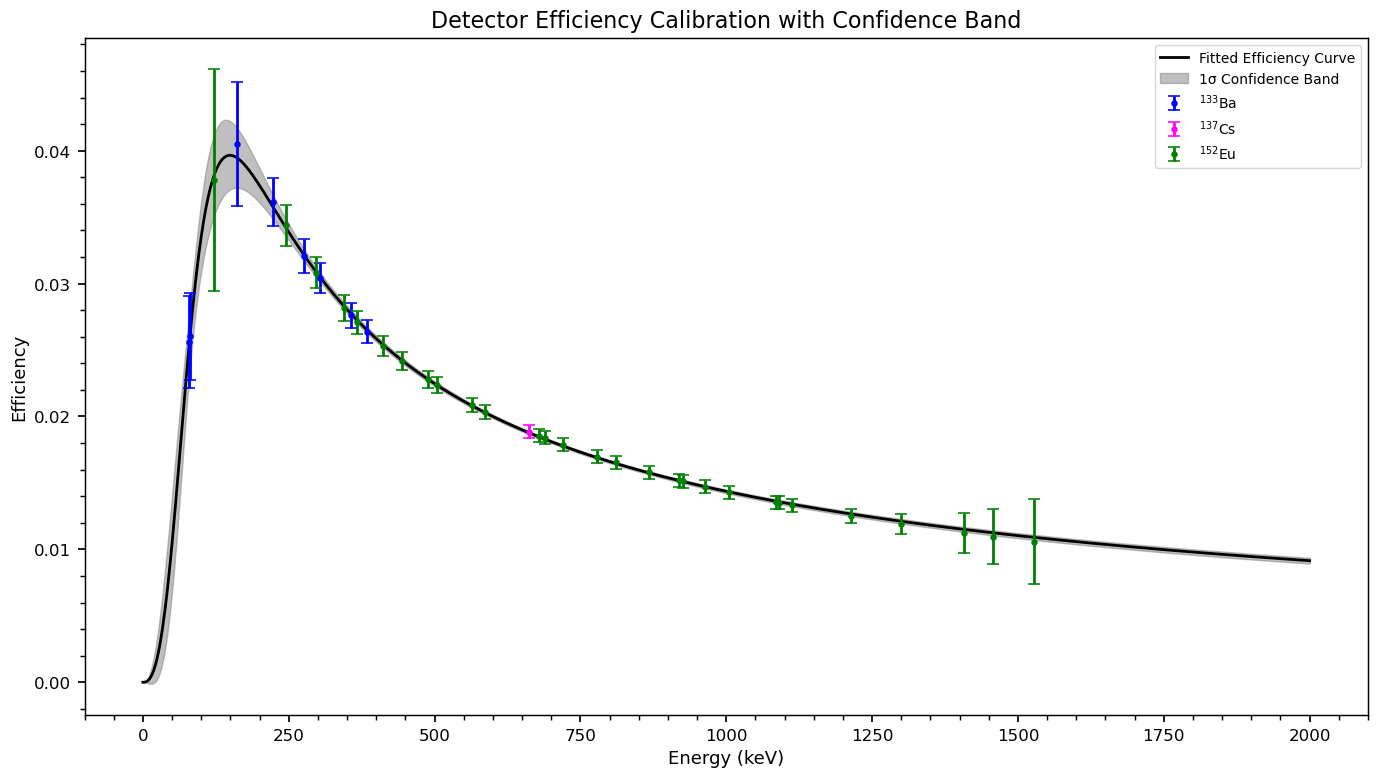

In [5]:
isotope_energy_set = []
efficiencies = []
unc_efficiencies = []
isotopes = []

for sp in [sp_Ba133, sp_Cs137, sp_Eu152]:
    for energy, ε, unc_ε, iso in zip(sp.peaks['energy'], sp.peaks['efficiency'], sp.peaks['unc_efficiency'], sp.peaks['isotope']):
        isotope_energy_set.append(energy)
        efficiencies.append(ε)
        unc_efficiencies.append(unc_ε)
        isotopes.append(iso)

isotope_energy_set = np.array(isotope_energy_set)
efficiencies = np.array(efficiencies)
unc_efficiencies = np.array(unc_efficiencies)
        
def efficiency_curve(E, a, b, c, d):
    return a * E**b/(c + E**d)

# Fit the efficiency data to the model
p0 = [20, 1, 5e+4, 2]  # Initial guess for parameters from testing parameters manually
efficiency_curve_params, cov = curve_fit(efficiency_curve, isotope_energy_set, efficiencies, p0=[20, 1, 5e+4, 2], sigma=unc_efficiencies, absolute_sigma=True)

energy_range = np.linspace(0, 2000, 1000)
fitted_efficiency = efficiency_curve(energy_range, *efficiency_curve_params)

# Create correlated ufloat objects for the fitted parameters
u_efficiency_curve_params = correlated_values(efficiency_curve_params, cov)
# Calculate the fitted efficiency with uncertainties
u_fitted_efficiency = efficiency_curve(energy_range, *u_efficiency_curve_params)
# Extract nominal values and standard deviations
fitted_efficiency_nom = unumpy.nominal_values(u_fitted_efficiency)
fitted_efficiency_std = unumpy.std_devs(u_fitted_efficiency)



# Plotting the confidence band
plt.plot(energy_range, fitted_efficiency_nom, color='black', label='Fitted Efficiency Curve')
plt.fill_between(energy_range, 
                 fitted_efficiency_nom - fitted_efficiency_std, 
                 fitted_efficiency_nom + fitted_efficiency_std, 
                 color='gray', alpha=0.5, label='1σ Confidence Band')

plt.errorbar(sp_Ba133.peaks['energy'], sp_Ba133.peaks['efficiency'], yerr=sp_Ba133.peaks['unc_efficiency'], fmt='o', label=r'$^{133}$Ba', color='blue')
plt.errorbar(sp_Cs137.peaks['energy'], sp_Cs137.peaks['efficiency'], yerr=sp_Cs137.peaks['unc_efficiency'], fmt='o', label=r'$^{137}$Cs', color='magenta')
plt.errorbar(sp_Eu152.peaks['energy'], sp_Eu152.peaks['efficiency'], yerr=sp_Eu152.peaks['unc_efficiency'], fmt='o', label=r'$^{152}$Eu', color='green')

plt.xlabel('Energy (keV)')
plt.ylabel('Efficiency')
plt.title('Detector Efficiency Calibration with Confidence Band')
plt.legend()
plt.show()

## Testing

<Figure size 1400x800 with 0 Axes>

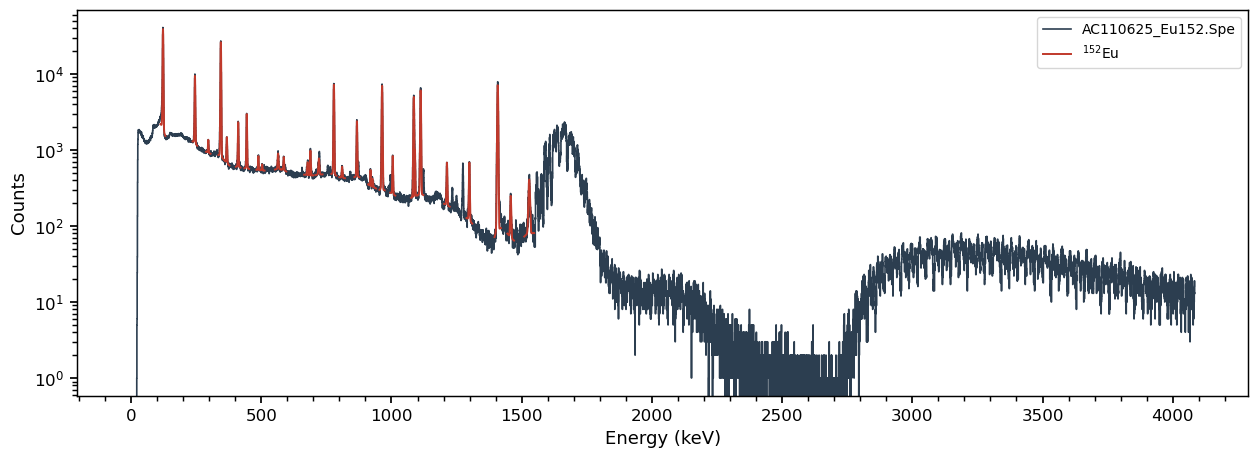

In [6]:
sp_Eu152.cb = cb
plt.clf()
fig, ax = sp_Eu152.plot(return_plot=True)

In [7]:
# sp_Eu152.sumamrize()
a = set()
a.update(zip(sp_Ba133.peaks['energy'].array, sp_Ba133.peaks['isotope'].array))
print(a)
print(*sp_Ba133.peaks['energy'].array)

{(223.2368, '133BA'), (80.9979, '133BA'), (79.6142, '133BA'), (276.3989, '133BA'), (383.8485, '133BA'), (302.8508, '133BA'), (160.612, '133BA'), (356.0129, '133BA')}
79.6142 80.9979 160.612 223.2368 276.3989 302.8508 356.0129 383.8485


In [8]:
def energy_data(sp: ci.Spectrum) -> list[tuple[float, dict]]:
    """Extract energy from Spectrum object""" 
    energies = []
    for E, iso, N_c, unc_N_c, I, unc_I, ε, unc_ε, λ, unc_λ, rt, lt in zip(sp.peaks['energy'].array, sp.peaks['isotope'],
                                                                     sp.peaks['counts'].array, sp.peaks['unc_counts'].array, 
                                                                     sp.peaks['intensity'].array, sp.peaks['unc_intensity'].array, 
                                                                     sp.peaks['efficiency'].array, sp.peaks['unc_efficiency'].array, sp.peaks['decay_rate'].array, sp.peaks['unc_decay_rate'].array, 
                                                                     sp.peaks['real_time'].array, sp.peaks['live_time'].array
                                                          ):
        data = {
            'isotope': iso,
            'counts': N_c,
            'unc_counts': unc_N_c,
            'intensity': I,
            'unc_intensity': unc_I,
            'efficiency': ε,
            'unc_efficiency': unc_ε,
            # 'decay_rate': λ,
            # 'unc_decay_rate': unc_λ,
            'real_time': rt,
            'live_time': lt    
        }
        data['decay_rate'] = ci.Isotope(iso).decay_const()
        
        
        energies.append((E, data))
        
    return energies


def Activity(t, A0, λ):
    return A0*np.exp(-λ*t)

In [9]:
job_name = 'job1_Ag4_1min_real10_loop6_'
spec_filename = spec_exp_path / (job_name + '001.Spe')

sp = ci.Spectrum(spec_filename)
# Note: Can use the calibration object created above, but we already saved it to a file
# sp.cb = cb
sp.cb = ci.Calibration(root_path / 'calibration.json')
sp.isotopes = ['108AG', '110AG']

print('Energies and counts:')
isotope_energy_set = energy_data(sp)
print(isotope_energy_set)

# sp.plot(return_plot=True)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_001.Spe
Energies and counts:
[(433.96, {'isotope': '108AG', 'counts': 26.66623270881777, 'unc_counts': 5.846834261363426, 'intensity': 0.005, 'unc_intensity': 0.00025, 'efficiency': 0.02450041949967394, 'unc_efficiency': 0.0007184038689308501, 'real_time': 10.0, 'live_time': 9.0, 'decay_rate': 0.004849896309543418}), (632.98, {'isotope': '108AG', 'counts': 31.873431083603947, 'unc_counts': 5.528830490963141, 'intensity': 0.0176, 'unc_intensity': 0.001, 'efficiency': 0.019405772268799335, 'unc_efficiency': 0.0005125029458983969, 'real_time': 10.0, 'live_time': 9.0, 'decay_rate': 0.004849896309543418}), (657.5, {'isotope': '110AG', 'counts': 320.5436318783905, 'unc_counts': 14.970488234371642, 'intensity': 0.045, 'unc_intensity': 0.0022500000000000003, 'efficiency': 0.01894346257453844, 'unc_efficiency': 0.0005046895008075428, 'real_time': 10.0, 'live_time': 9.0, 'decay_rate': 0.02817671465690

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_001.Spe


/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_003.Spe


/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_005.Spe


/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


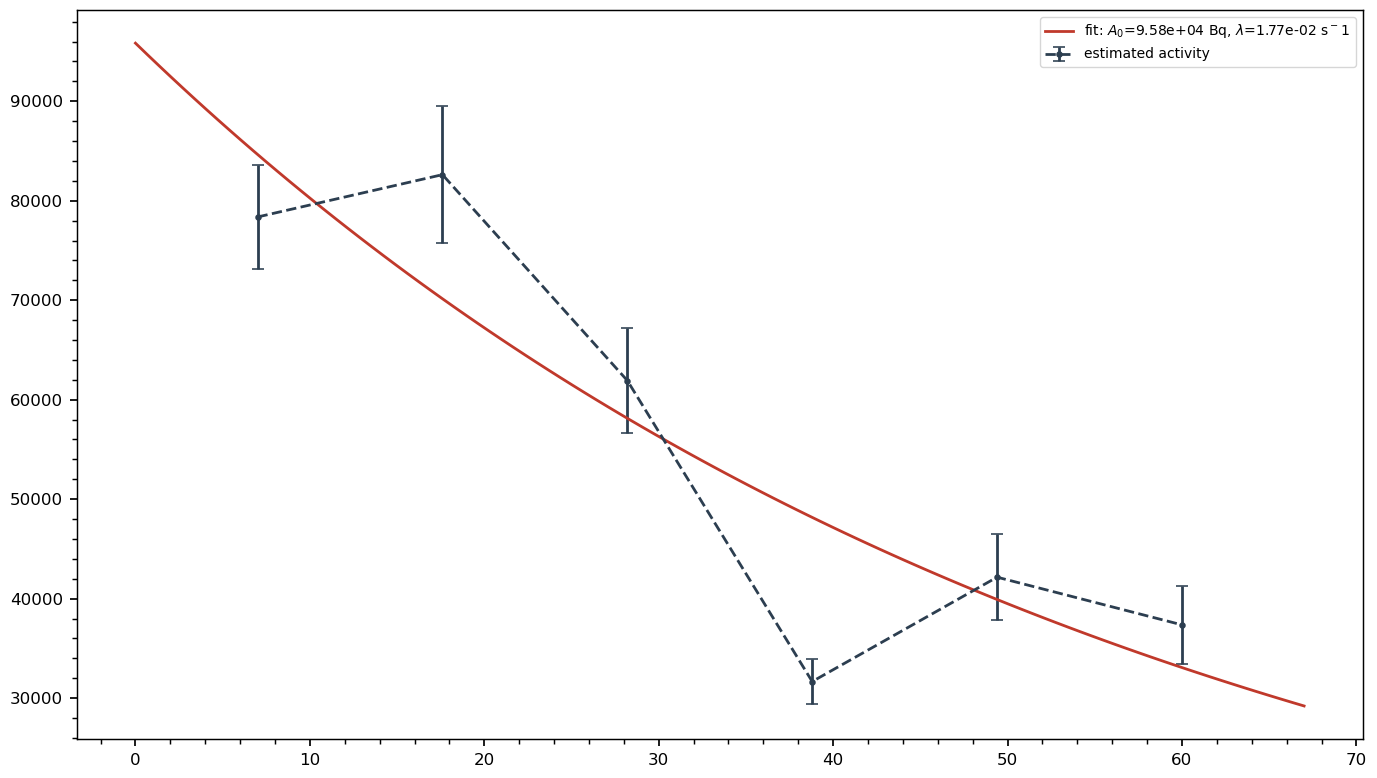

In [10]:
job_name = 'job1_Ag4_1min_real10_loop6_'
activities = []
uncertancies = []

n_loops = 6
for i in range(n_loops):
    spec_filename = spec_exp_path / (job_name + f'{i:03d}.Spe')
    sp5 = ci.Spectrum(spec_filename)
    sp5.cb = ci.Calibration(root_path / 'calibration.json')
    sp5.isotopes = ['108AG', '110AG']
    
    A = ufloat(0, 0)
    for energy, data in energy_data(sp5):
        isotope = data['isotope']
        N_c     = data['counts']
        unc_N_c = data['unc_counts']
        λ       = data['decay_rate']
        I_γ     = data['intensity']
        unc_I_γ = data['unc_intensity']   
        ε       = data['efficiency']
        unc_ε   = data['unc_efficiency']
        Δt_c    = data['live_time']
        Δt_r    = data['real_time']
        
        N_c_u = ufloat(N_c, unc_N_c)
        I_γ_u = ufloat(I_γ, unc_I_γ)
        ε_u   = ufloat(ε, unc_ε)
        
        A += (N_c_u * λ)/(ε_u*I_γ_u*(1 - uexp(-λ*Δt_c)))

     
     
    activities.append(A.nominal_value)
    uncertancies.append(A.std_dev) 
    # activities.append(A/Δt_r) ? 
plt.clf()

isotope_energy_set = energy_data(sp5)
period = data['real_time']
start = 7 # s
real_times = np.linspace(start, n_loops*period, n_loops)
actual_time = np.linspace(0, start + n_loops*period, 100)

p0 = (1000, 0.01)
efficiency_curve_params, cv = curve_fit(Activity, real_times, activities, p0=p0)
A0, λ = efficiency_curve_params

plt.clf()
plt.errorbar(real_times, activities, yerr=uncertancies, fmt='o--', label = 'estimated activity')
plt.plot(actual_time, Activity(actual_time, A0, λ), label = fr'fit: $A_0$={A0:.2e} Bq, $λ$={λ:.2e} s$^{-1}$')

plt.legend()
plt.show()

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_002.Spe


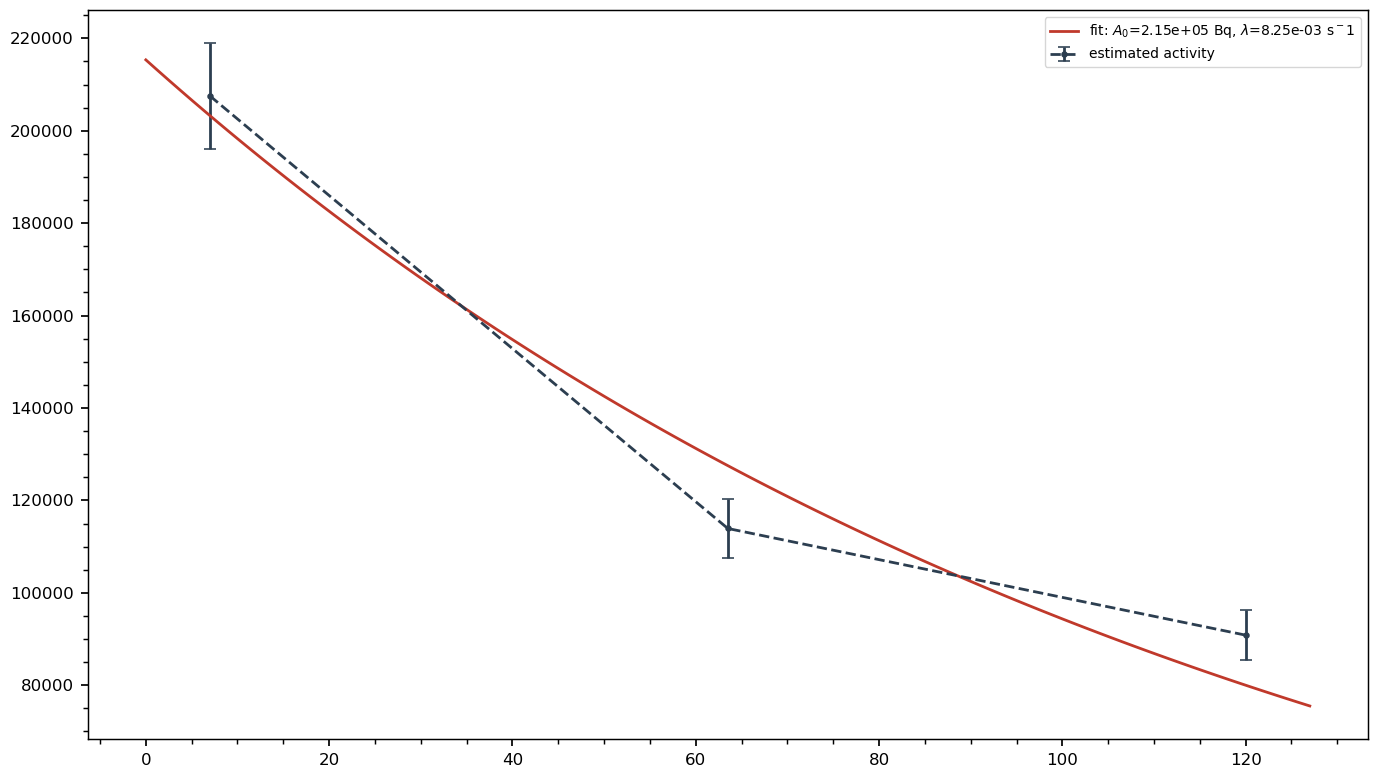

In [11]:
job_name = 'job3_Ag73_3min_real40_loop3_'
activities = []
uncertancies = []

n_loops = 3
for i in range(n_loops):
    spec_filename = spec_exp_path / (job_name + f'{i:03d}.Spe')
    sp5 = ci.Spectrum(spec_filename)
    sp5.cb = ci.Calibration(root_path / 'calibration.json')
    sp5.isotopes = ['108AG', '110AG']
    
    A = ufloat(0, 1e-16) # Small uncertainty to avoid warning
    for energy, data in energy_data(sp5):
        isotope = data['isotope']
        N_c     = data['counts']
        unc_N_c = data['unc_counts']
        λ       = data['decay_rate']
        I_γ     = data['intensity']
        unc_I_γ = data['unc_intensity']   
        ε       = data['efficiency']
        unc_ε   = data['unc_efficiency']
        Δt_c    = data['live_time']
        Δt_r    = data['real_time']
        
        N_c_u = ufloat(N_c, unc_N_c)
        I_γ_u = ufloat(I_γ, unc_I_γ)
        ε_u   = ufloat(ε, unc_ε)
        
        A += (N_c_u * λ)/(ε_u*I_γ_u*(1 - uexp(-λ*Δt_c)))

     
     
    activities.append(A.nominal_value)
    uncertancies.append(A.std_dev)
    # TODO normalize to real time ?
    # activities.append(A/Δt_r)
plt.clf()

isotope_energy_set = energy_data(sp5)
period = data['real_time']
start = 7 # s
real_times = np.linspace(start, n_loops*period, n_loops)
actual_time = np.linspace(0, start + n_loops*period, 100)

p0 = (1000, 0.01)
efficiency_curve_params, cv = curve_fit(Activity, real_times, activities, p0=p0)
A0, λ = efficiency_curve_params


plt.clf()
plt.errorbar(real_times, activities, yerr=uncertancies, fmt='o--', label = 'estimated activity')
plt.plot(actual_time, Activity(actual_time, A0, λ), label = fr'fit: $A_0$={A0:.2e} Bq, $λ$={λ:.2e} s$^{-1}$')

plt.legend()
plt.show()

In [12]:
iso1 = ci.Isotope('108AG')
iso2 = ci.Isotope('110AG')

print(f"108Ag decay constant: {iso1.decay_const()} s^-1")
print(f"110Ag decay constant: {iso2.decay_const()} s^-1")

print(f"108Ag half-life: {iso1.half_life()} s")
print(f"110Ag half-life: {iso2.half_life()} s")

108Ag decay constant: 0.004849896309543418 s^-1
110Ag decay constant: 0.028176714656908342 s^-1
108Ag half-life: 142.92 s
110Ag half-life: 24.6 s


## Analysis

In [ ]:
from dataclasses import dataclass, field

@dataclass
class GammaPeak:
    """
    Data class to hold measurements for a specific gamma-ray energy peak.

    Parameters
    ----------
    energy : float
        The gamma-ray energy in keV.

    Attributes
    ----------
    energy : float
        The gamma-ray energy in keV.
    times : list[float]
        List of measurement times in seconds since the end of irradiation.
    activities : list[float]
        List of measured activities in Bq.
    uncertainties : list[float]
        List of uncertainties in the measured activities.
    n_measurements : int
        The number of measurements for this peak.
        
    Methods
    -------
    add_measurement(time: float, activity: float, uncertainty: float) -> None
        Add a new measurement for this energy peak.
    
    """
    energy: float  # The gamma-ray energy in keV
    # Store measurement data
    times: list[float] = field(default_factory=list)
    activities: list[float] = field(default_factory=list)
    uncertainties: list[float] = field(default_factory=list)
    
    def add_measurement(self, time: float, activity: float, uncertainty: float) -> None:
        """Add a new measurement for this energy peak."""
        self.times.append(time)
        self.activities.append(activity)
        self.uncertainties.append(uncertainty)
   
    @property
    def n_measurements(self) -> int:
        """Return the number of measurements for this peak."""
        return len(self.times)

@dataclass
class IsotopeResults:
    """
    Stores analysis results for a single isotope.

    This data class aggregates all measurements for a specific isotope, organized
    by gamma-ray energy peaks. It also stores the optimal parameters from the
    curve fit.

    Parameters
    ----------
    isotope : str
        The identifier for the isotope (e.g., '108AG').
    peaks : list[GammaPeak], optional
        A list of `GammaPeak` objects for this isotope. Initialized to an empty list.
    A0 : ufloat, optional
        The fitted initial activity (A0) at t=0, as a `ufloat` object from the
        `uncertainties` library. Initialized to 0.
    cov : np.ndarray, optional
        The covariance matrix from the activity curve fit. Initialized to None.

    Attributes
    ----------
    isotope : str
        The identifier for the isotope.
    peaks : list[GammaPeak]
        List of `GammaPeak` objects, each containing measurements for a specific
        gamma-ray energy.
    A0 : ufloat
        The fitted initial activity (A0) at t=0 with its uncertainty.
    cov : np.ndarray
        The covariance matrix from the fit.

    Methods
    -------
    get_peak(energy: float, tolerance: float = 0.5) -> GammaPeak | None
        Finds a `GammaPeak` object for a given energy within a tolerance.
    add_or_update_peak(energy: float, time: float, activity: float, uncertainty: float, tolerance: float = 0.5) -> None
        Adds a measurement to an existing peak or creates a new one.
    """
    isotope: str
    peaks: list[GammaPeak] = field(default_factory=list)
    A0: ufloat = ufloat(0, 1e-16)
    cov: np.ndarray = None
    
    def _get_peak(self, energy: float, tolerance: float = 0.5) -> GammaPeak | None:
        """
        Find a peak with the given energy within the specified tolerance.
        Returns None if no matching peak is found.
        """
        for peak in self.peaks:
            if abs(peak.energy - energy) <= tolerance:
                return peak
        return None
    
    def add_or_update_peak(self, energy: float, time: float, activity: float, 
                           uncertainty: float, tolerance: float = 0.5) -> None:
        """
        Adds a measurement to an existing peak or creates a new one.

        This method searches for a `GammaPeak` corresponding to the given `energy`
        within a specified `tolerance`. If a matching peak is found, the new
        measurement (time, activity, uncertainty) is added to it. If no
        matching peak is found, a new `GammaPeak` is created and the
        measurement is added to the new peak.

        Parameters
        ----------
        energy : float
            The gamma-ray energy of the measurement in keV.
        time : float
            The measurement time in seconds since the end of irradiation.
        activity : float
            The measured activity in Bq.
        uncertainty : float
            The uncertainty in the measured activity.
        tolerance : float, optional
            The tolerance in keV for matching an existing energy peak, by default 0.5.
        """
        peak = self._get_peak(energy, tolerance)
        if peak is None:
            # Create a new peak
            peak = GammaPeak(energy=energy)
            self.peaks.append(peak)
        
        # Add the measurement to the peak
        peak.add_measurement(time, activity, uncertainty)
    
class SpectrumAnalysis:
    """
    Analyzes a series of gamma-ray spectrum files to determine the initial
    activity (A0) of specified isotopes.

    This class automates the process of reading multiple spectrum files from a
    time-series measurement, extracting peak information, calculating activities
    for each peak, and performing a combined curve fit to determine the initial
    activity at the end of irradiation.

    Parameters
    ----------
    spec_filename : str
        The base filename for the spectrum files. The class expects a series
        of files named like `spec_filename_000.Spe`, `spec_filename_001.Spe`, etc.
    Δt_d : float
        The delay time in seconds between the end of irradiation and the start
        of the first measurement.
    calibration_source : str or ci.Calibration, optional
        The path to the calibration file (e.g., 'calibration.json') or a
        pre-loaded `curie.calibration.Calibration` object. Defaults to a file named
        'calibration.json' in the root path.

    Attributes
    ----------
    spec_filename : pathlib.Path
        The path object for the base spectrum filename.
    Δt_d : float
        Delay time in seconds.
    cb : curie.calibration.Calibration
        The calibration object used for analysis.
    job_specs : dict
        A dictionary containing specifications extracted from the filename,
        such as job number, plate number, and irradiation time.
    spectrums : np.ndarray
        An array of `curie.spectrum.Spectrum` objects, one for each measurement loop.
    real_times : np.ndarray
        The real time for each measurement in seconds.
    live_times : np.ndarray
        The live time for each measurement in seconds.
    start_times : list[pd.Timestamp]
        The start time of each measurement.
    time_deltas : np.ndarray
        The time elapsed in seconds from the start of the first measurement
        to the start of each subsequent measurement.
    isotope_energy : set
        A set of tuples, where each tuple contains an isotope identifier and a
        gamma-ray energy (e.g., `('108AG', 632.9)`).
    Ag108 : IsotopeResults
        An `IsotopeResults` object containing all measurements and fit results
        for the 108Ag isotope.
    Ag110 : IsotopeResults
        An `IsotopeResults` object containing all measurements and fit results
        for the 110Ag isotope.
    true_times : np.ndarray
        The time for each measurement, corrected for the delay time `Δt_d`,
        in seconds since the end of irradiation.

    Methods
    -------
    plot_activity()
        Generates and displays plots of the activity decay curves for 108Ag and
        110Ag, showing individual peak measurements and the combined fit.

    """
    def __init__(self, spec_filename: str, Δt_d: float, calibration_source: str|ci.Calibration = root_path / 'calibration.json'):
        # --- Input Validation ---
        # Check for valid paths
        self.spec_filename = Path(spec_filename)
        spec_path_first_loop = Path(spec_filename + '_000.Spe')
        if not spec_path_first_loop.is_file():
            raise FileNotFoundError(f"First loop of spectrum file not found: {spec_path_first_loop}")
        
        # Check if calibration_file is a Path or a Calibration object
        if isinstance(calibration_source, Path):
            self.calib_path = calibration_source
            if self.calib_path.is_file():
                self.cb = ci.Calibration(self.calib_path)
            else:
                raise FileNotFoundError(f"Calibration file not found: {self.calib_path}")
            
        elif isinstance(calibration_source, ci.Calibration):
            self.calib_path = None
            self.cb = calibration_source
        else:
            raise TypeError("calibration_source must be a Path or a ci.Calibration object")
        
        # --- Initialization ---
        self.Δt_d = Δt_d  # Delay time between irradiation and measurement in seconds
        self.job_specs = self._get_job_specs()
        
        self.isotopes = ['108AG', '110AG']  # Isotopes to analyze
        self.fit_config = {'SNR_min': 3.5, 'dE_511': 9}  # Configuration for fitting
        
        # --- Data Extraction ---
        self.spectrums, self.real_times, self.live_times, self.start_times, self.time_deltas, self.isotope_energy = self._read_spectrums(self.job_specs)

        # --- Activity Calculations ---
        self.Ag108, self.Ag110 = self._calculate_activities(self.spectrums)

        # --- Fitting Activities ---
        self.true_times = self.time_deltas  + self.Δt_d  # Add delay time to real times
        self.Ag108.A0, self.Ag108.cov = self._fit_combined_activity(self.Ag108)
        self.Ag110.A0, self.Ag110.cov = self._fit_combined_activity(self.Ag110)
    

    def _get_job_specs(self):
        """Extract job specifications from the spectrum filename."""
        parts = self.spec_filename.stem.split('_')
        job_specs = {
            'job_number': int(parts[0][3:]),  # Extract job number from 'job1_' -> 1
            'plate_number': int(parts[1][2:]),  # Extract plate number from 'Ag4_' -> 4
            'irradiation_time': int(parts[2][0]), # Extract irradiation time from '1min' -> 1
            'real_time': int(parts[3][4:]),  # Extract real time from 'real10' -> 10
            'num_loops': int(parts[4][4:])  # Extract number of loops from 'loop6' -> 6
            }
        
        return job_specs
    
    def _read_spectrums(self, job_specs: dict[str, int]) -> tuple[np.ndarray, np.ndarray, np.ndarray, list[pd.Timestamp], np.ndarray, set]:
        """Read the spectrum files and return a list of Spectrum objects."""
        # TODO: When done, evalute what list are actually needed
        spectrums      = []
        real_times     = []
        live_times     = [] 
        start_times    = []
        time_deltas    = []
        isotope_energy = set() # ('isotope1', energy1, 'isotope1', energy2, 'isotope2', energy3, ...) 
        
        n_loops = job_specs['num_loops']
        for i in range(n_loops):
            spec_path = self.spec_filename + f'_{i:03d}.Spe'
            spectrum = ci.Spectrum(spec_path)
            spectrum.cb = self.cb
            spectrum.isotopes = self.isotopes
            spectrum.fit_config = self.fit_config
            
            spectrums.append(spectrum)
            real_times.append(spectrum.peaks['real_time'].array[0])  # All peaks have the same real time
            live_times.append(spectrum.peaks['live_time'].array[0])  # All peaks have the same live time
            start_times.append(pd.Timestamp(spectrum.peaks['start_time'].array[0]))  # All peaks have the same start time
            time_deltas.append(pd.Timedelta(start_times[-1] - start_times[0]).total_seconds())
            # Add energies to the set
            isotope_energy.update((zip(spectrum.peaks['isotope'].array, spectrum.peaks['energy'].array)))
            
        real_times  = np.array(real_times)
        live_times  = np.array(live_times)
        spectrums   = np.array(spectrums)
        time_deltas = np.array(time_deltas)
        
        return spectrums, real_times, live_times, start_times, time_deltas, isotope_energy
    
    def _calculate_activities(self, spectrums):
        """Calculate activities for each gamma peak in each spectrum."""
        Ag108 = IsotopeResults('108AG')
        Ag110 = IsotopeResults('110AG')
        self.A0_analytical_108 = []
        self.A0_analytical_110 = []
        # Process each spectrum
        for spec_idx, (spec, time_delta) in enumerate(zip(spectrums, self.time_deltas)):
            # Calculate true time (time since end of irradiation)
            true_time = time_delta + self.Δt_d
            
            # Process each peak in the spectrum
            for E, iso, N_c, unc_N_c, I, unc_I, ε, unc_ε, λ, unc_λ, rt, lt, st in zip(
                    spec.peaks['energy'].array, 
                    spec.peaks['isotope'],
                    spec.peaks['counts'].array, 
                    spec.peaks['unc_counts'].array, 
                    spec.peaks['intensity'].array, 
                    spec.peaks['unc_intensity'].array, 
                    spec.peaks['efficiency'].array, 
                    spec.peaks['unc_efficiency'].array, 
                    spec.peaks['decay_rate'].array, 
                    spec.peaks['unc_decay_rate'].array,
                    spec.peaks['real_time'].array,
                    spec.peaks['live_time'].array,
                    spec.peaks['start_time'].array):
                
                # Get decay constant from isotope library
                λ, unc_λ = ci.Isotope(iso).decay_const(unc=True)
                
                λ_u = ufloat(λ, unc_λ)
                N_c_u = ufloat(N_c, unc_N_c)
                I_u = ufloat(I, unc_I)
                ε_u = ufloat(ε, unc_ε)
                
                # Calculate activity for this peak
                # TODO Is this the correct formula?
                A = (N_c_u * λ_u) / (ε_u * I_u * (1 - uexp(-λ_u * lt)))
                A0_approx = self.A0_func(N_c_u, λ_u, ε_u, I_u, lt, true_time)
                
                # Add the measurement to the appropriate isotope result
                if iso == '108AG':
                    Ag108.add_or_update_peak(
                        energy=E, 
                        time=true_time,
                        activity=A.nominal_value,
                        uncertainty=A.std_dev
                    )
                    self.A0_analytical_108.append(A0_approx.nominal_value)
                elif iso == '110AG':
                    Ag110.add_or_update_peak(
                        energy=E, 
                        time=true_time,
                        activity=A.nominal_value,
                        uncertainty=A.std_dev
                    )
                    self.A0_analytical_110.append(A0_approx.nominal_value)
                else:
                    print(f"Warning: Unrecognized isotope {iso} in spectrum {spec_idx}. Skipping.")
        
        return Ag108, Ag110
                    
    def _fit_combined_activity(self, iso_results: IsotopeResults):
        """Fit activity curve using all peaks for an isotope."""
        # Collect all times, activities, and uncertainties across all peaks
        all_times = []
        all_activities = []
        all_uncertainties = []

        for peak in iso_results.peaks:
            all_times.extend(peak.times)
            all_activities.extend(peak.activities)
            all_uncertainties.extend(peak.uncertainties)
            
        if len(all_times) == 0:
            raise ValueError(f"No measurements found for isotope {iso_results.isotope}. Cannot fit activity curve.")

        # Sorts all data by time
        sorted_data = sorted(zip(all_times, all_activities, all_uncertainties), key=lambda x: x[0])
        all_times, all_activities, all_uncertainties = zip(*sorted_data)
        
        # Fitting the data
        λ = ci.Isotope(iso_results.isotope).decay_const()
        try:
            params, cov = curve_fit(
                lambda t, A0: self._activity_model(t, λ, A0),
                all_times, 
                all_activities, 
                p0=[max(all_activities)], 
                sigma=all_uncertainties, 
                absolute_sigma=True
            )
            A0 = ufloat(params[0], np.sqrt(cov[0, 0]))
            return A0, cov
        
        except ValueError:
            raise ValueError(f'Error fitting activity as measurement data contains NaN, inf.\nTimes: {all_times}\nActicvities: {all_activities}')

        except RuntimeError:
            raise RuntimeError(f'Failed least squares fit for isotope {iso_results.isotope}. Check data quality or fitting parameters.')
            
    def _plot_isotope_data(self, ax, iso_results):
        """Plot data for a specific isotope."""
        # Check iso_results for possible issues
        
        
        # TODO Evalute using differnt colors
        # Use a different color for each energy peak
        # colors = plt.cm.tab10(np.linspace(0, 1, len(iso_results.peaks)))
        # colors = plt.cm.brg(np.linspace(0, 1, len(iso_results.peaks)))
        colors = plt.cm.Set1(np.linspace(0, 1, len(iso_results.peaks)))
        
        # Plot each energy peak with its own color
        for i, peak in enumerate(iso_results.peaks):
            # if peak.n_measurements > 0:
            label = f"{peak.energy:.1f} keV"
            ax.errorbar(
                peak.times, 
                peak.activities, 
                yerr=peak.uncertainties, 
                fmt='o:', 
                capsize=5,
                # color=colors[i],
                label=label,
                alpha=1-.2*i,  # Decrease alpha for each peak
            )
        
        # Get time range for plotting
        all_times = []
        for peak in iso_results.peaks:
            all_times.extend(peak.times)
        
        # if all_times:
        t_min = min(all_times)
        t_max = max(all_times)
        plot_times = np.linspace(0, t_max * 1.1, 100)
        
        # Get decay constant
        λ = ci.Isotope(iso_results.isotope).decay_const()
        
        # Plot fit line
        fit_line = self._activity_model(plot_times, λ, iso_results.A0.nominal_value)
        ax.plot(plot_times, fit_line, 'k-', 
                label=f'Combined Fit')
        
        # Plot confidence band
        # if iso_results.cov is not None:
        # Calculate uncertainty in fit
        fit_unc = np.abs(fit_line * (iso_results.A0.std_dev / iso_results.A0.nominal_value))
        ax.fill_between(plot_times, 
                    fit_line - fit_unc, 
                    fit_line + fit_unc, 
                    color='gray', alpha=0.3, label='1σ Confidence Band')

    
        # formatted_iso_name = rf'$^{iso_results.isotope[:3]}$Ag'
        formatted_iso_name = rf'$^{{{iso_results.isotope[:3]}}}$Ag'
        ax.set_title(formatted_iso_name + f'\nA₀={iso_results.A0:.2uP} Bq')
        ax.set_xlabel('Time since irradiation end [s]')
        ax.set_ylabel('Activity [Bq]')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def plot_activity(self, save_fig: bool = True):
        """Plot activities for each isotope, with different colors for different energy peaks."""
        plt.figure()
        # Plot 108Ag data
        ax1 = plt.subplot(1, 2, 1)
        self._plot_isotope_data(ax1, self.Ag108)
        
        # Plot 110Ag data
        ax2 = plt.subplot(1, 2, 2)
        self._plot_isotope_data(ax2, self.Ag110)
        
        plt.suptitle(f'Activity Analysis for {self.spec_filename.stem}')
        plt.tight_layout()
        
        if save_fig:
            path = fig_path / f'{self.spec_filename.stem}_activity_analysis'
            plt.savefig(path.with_suffix('.pdf'))
            plt.savefig(path.with_suffix('.png'))
        plt.show()
    
    def plot_A0_analytical(self, save_fig: bool = True):
        """Plot the analytical A0 values for each isotope and peak."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

        # --- Plot for 108Ag ---
        for peak in self.Ag108.peaks:
            # Filter the A0 values for the current peak energy
            a0_values = [a0 for e, a0 in zip(self.A0_analytical_108, self.A0_analytical_108) if abs(e - peak.energy) < 0.5]
            ax1.plot(range(len(a0_values)), a0_values, 'o--', label=f'{peak.energy:.1f} keV')
        
        formatted_iso_name_108 = rf'$^{{{self.Ag108.isotope[:3]}}}$Ag'
        ax1.set_title(f'Analytical A₀ for {formatted_iso_name_108}')
        ax1.set_xlabel('Measurement Index')
        ax1.set_ylabel('Analytical A₀ [Bq]')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # --- Plot for 110Ag ---
        for peak in self.Ag110.peaks:
            # Filter the A0 values for the current peak energy
            a0_values = [a0 for e, a0 in zip(self.A0_analytical_110, self.A0_analytical_110) if abs(e - peak.energy) < 0.5]
            ax2.plot(range(len(a0_values)), a0_values, 'o--', label=f'{peak.energy:.1f} keV')

        formatted_iso_name_110 = rf'$^{{{self.Ag110.isotope[:3]}}}$Ag'
        ax2.set_title(f'Analytical A₀ for {formatted_iso_name_110}')
        ax2.set_xlabel('Measurement Index')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.suptitle(f'Analytical A₀ Calculation for {self.spec_filename.stem}')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        if save_fig:
            path = fig_path / f'{self.spec_filename.stem}_A0_analytical'
            plt.savefig(path.with_suffix('.pdf'))
            plt.savefig(path.with_suffix('.png'))
        plt.show()
        
        
    def _activity_model(self, t, λ, A0):
        """Model for activity decay."""
        return A0*np.exp(-λ*t)
    
    # TODO: Contemplate discarding analytical A0 calculation
    def A0_func(self, N_c, λ, ε, I_γ, Δt_c, Δt_d):
        return (N_c * λ) / (ε * I_γ * (1 - uexp(-λ * Δt_c))) * uexp(λ * Δt_d)

### Job 1:
- Plate id: 4
- Irradiation time: 1 min
- Real time: 10s 
- Num loops: 6

In [30]:
analysis_1 = SpectrumAnalysis(spec_exp_path / 'job1_Ag4_1min_real10_loop6', Δt_d=15)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_003.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_005.Spe


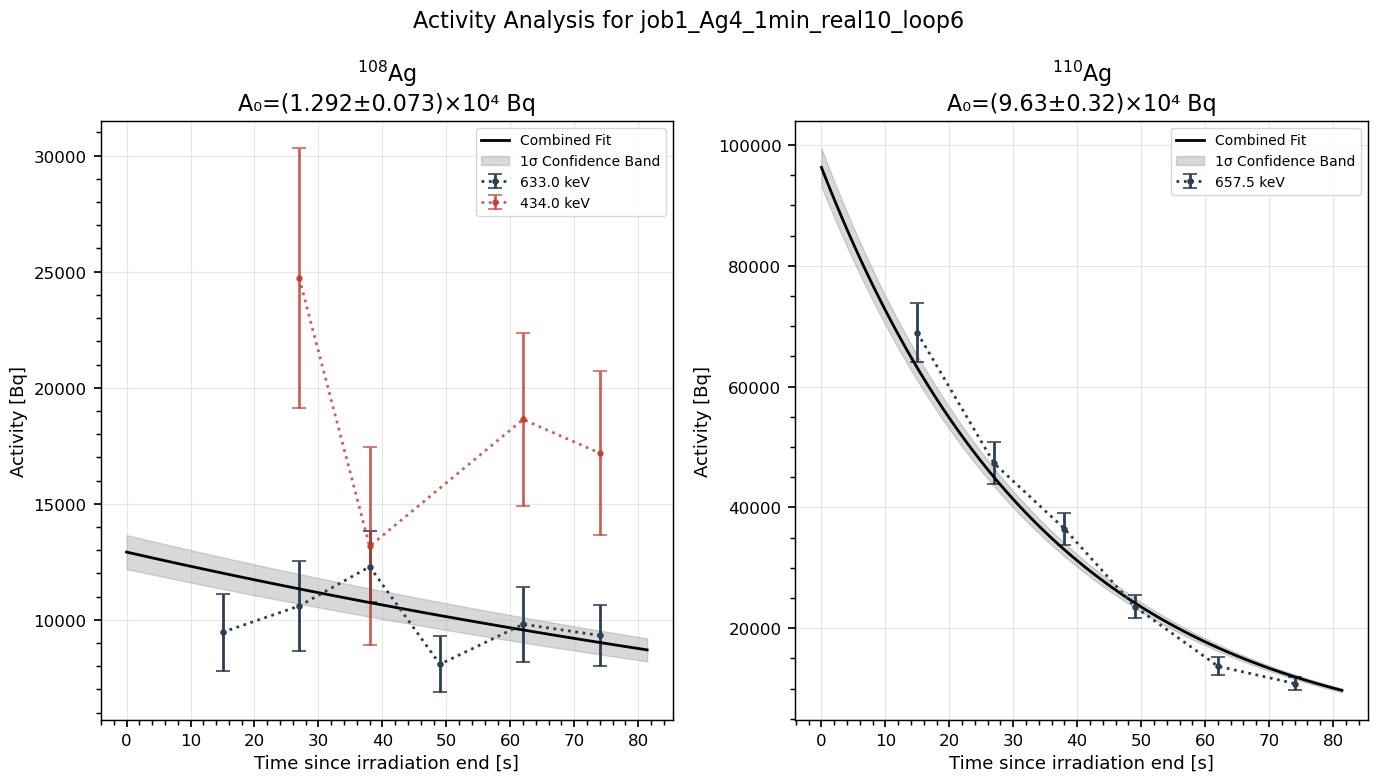

In [32]:
analysis_1.plot_activity()

### Job 2:
- Plate id: 10
- Irradiation time: 2 min
- Real time: 30s
- Num loops: 6

In [33]:
analysis_2 = SpectrumAnalysis(spec_exp_path / 'job2_Ag10_2min_real30_loop6', Δt_d=11)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_003.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_005.Spe


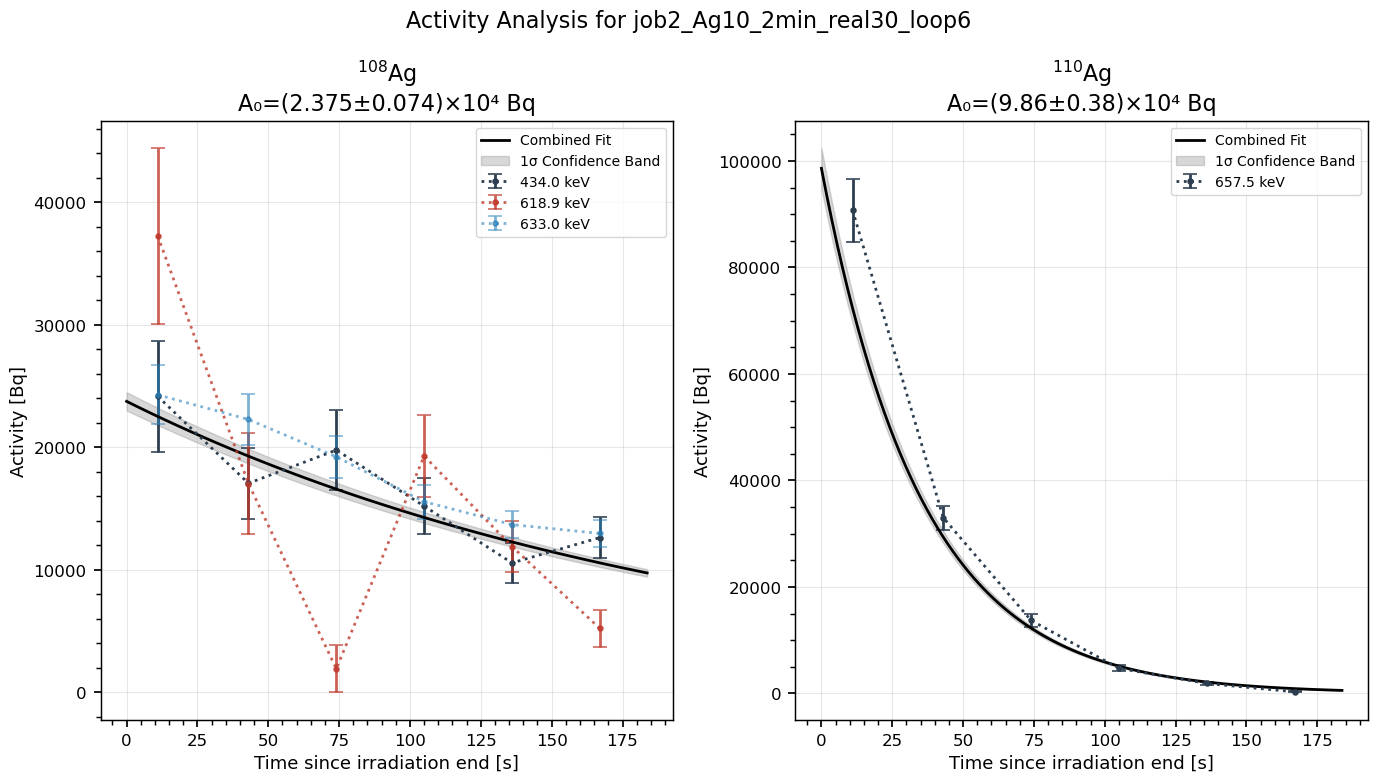

In [34]:
analysis_2.plot_activity()

### Job 3:
- Plate id: 73
- Irradiation time: 3 min
- Real time: 40s
- Num loops: 3

In [18]:
analysis_3 = SpectrumAnalysis(spec_exp_path / 'job3_Ag73_3min_real40_loop3', Δt_d=11)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_002.Spe


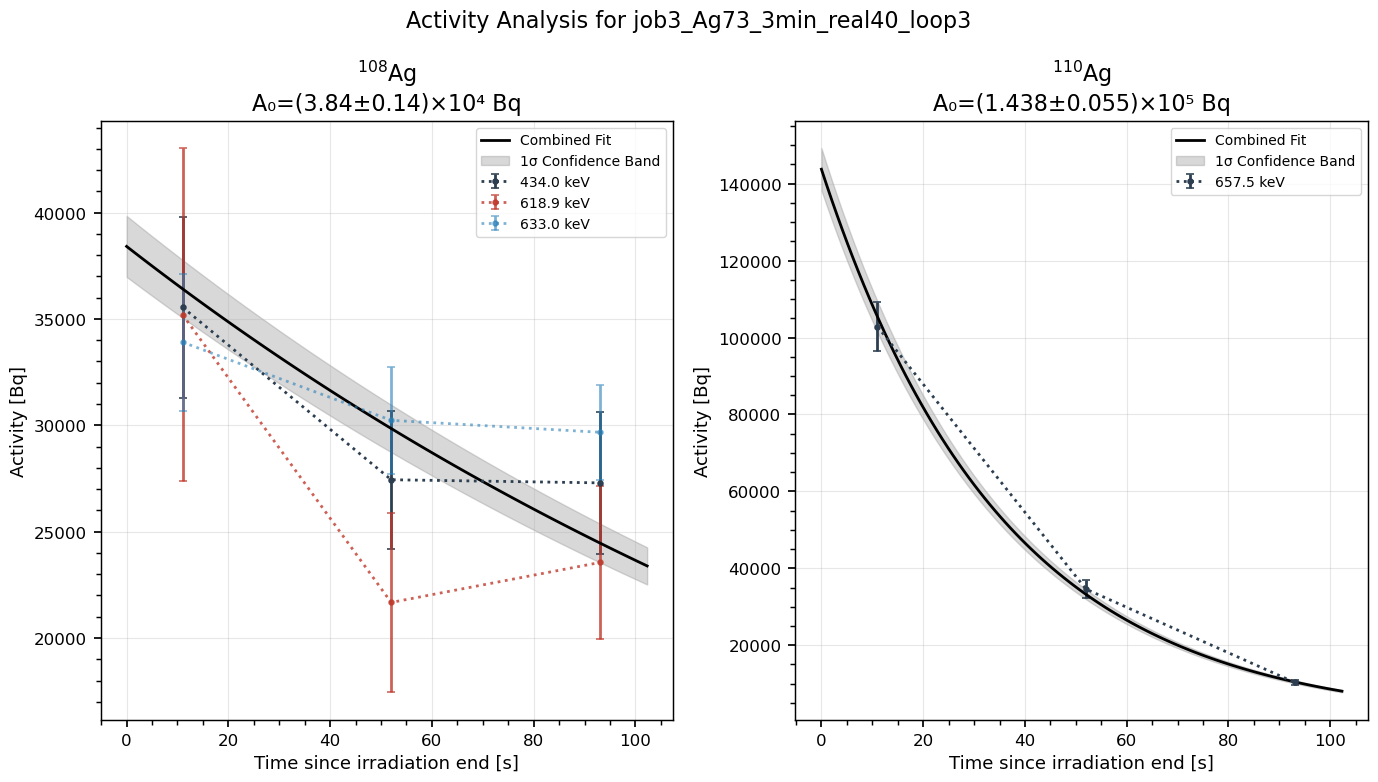

In [19]:
analysis_3.plot_activity()

### Job 4:
- Plate id: 2
- Irradiation time: 3 min
- Real time: 120s
- Num loops: 1

In [20]:
analysis_4 = SpectrumAnalysis(spec_exp_path / 'job4_Ag2_3min_real120_loop1', Δt_d=14)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job4_Ag2_3min_real120_loop1_000.Spe


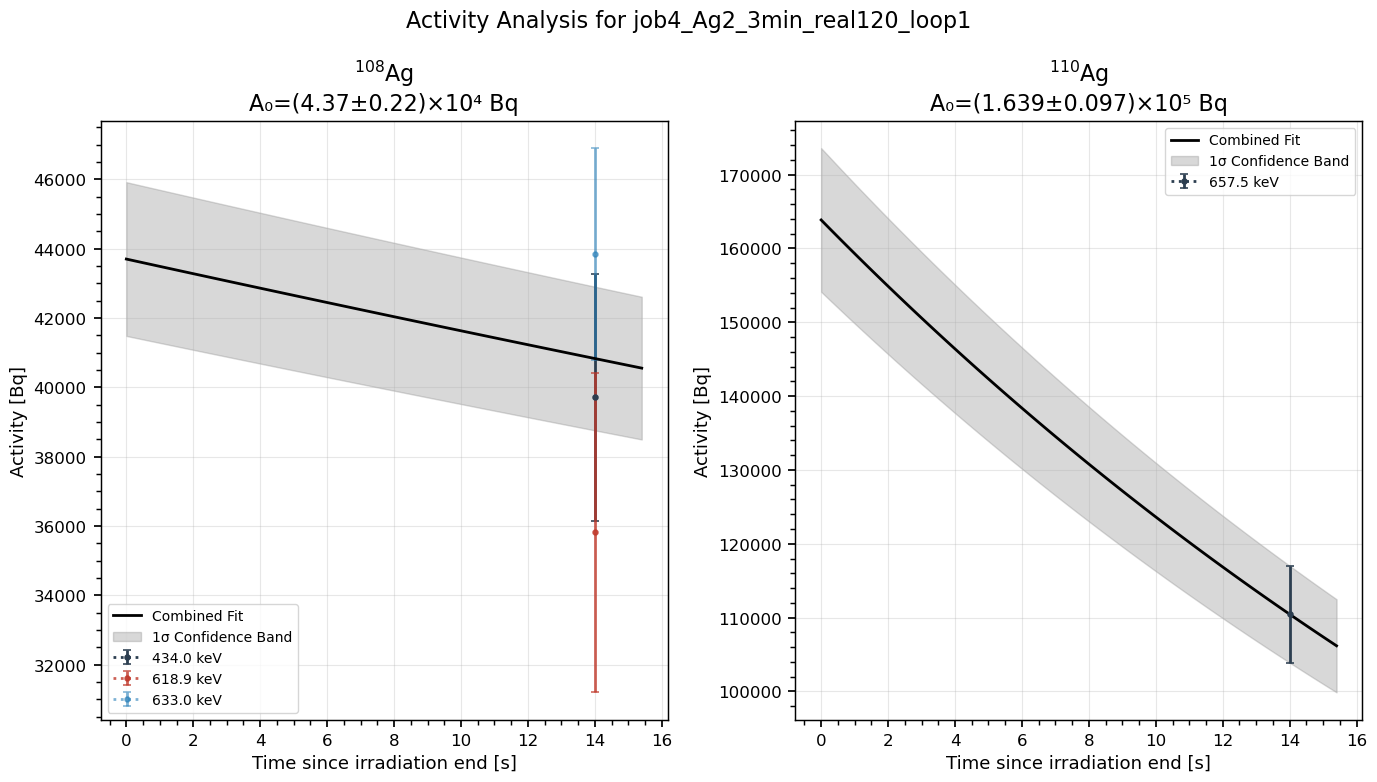

In [21]:
analysis_4.plot_activity()

### Job 5:
- Plate id: 4
- Irradiation time: 3 min
- Real time: 5s
- Num loops: 6

In [22]:
analysis_5 = SpectrumAnalysis(spec_exp_path / 'job5_Ag5_3min_real5_loop6', Δt_d=7)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_003.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_005.Spe


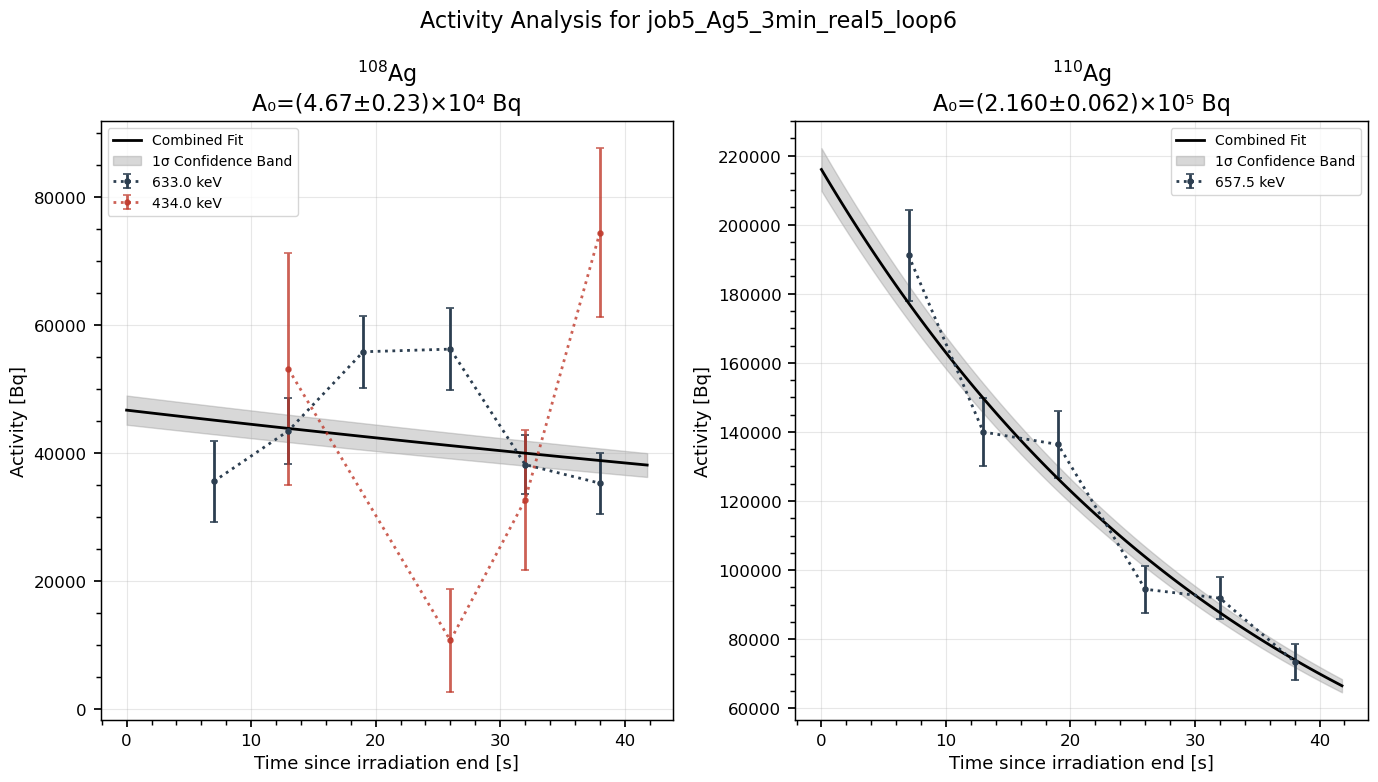

In [23]:
analysis_5.plot_activity()

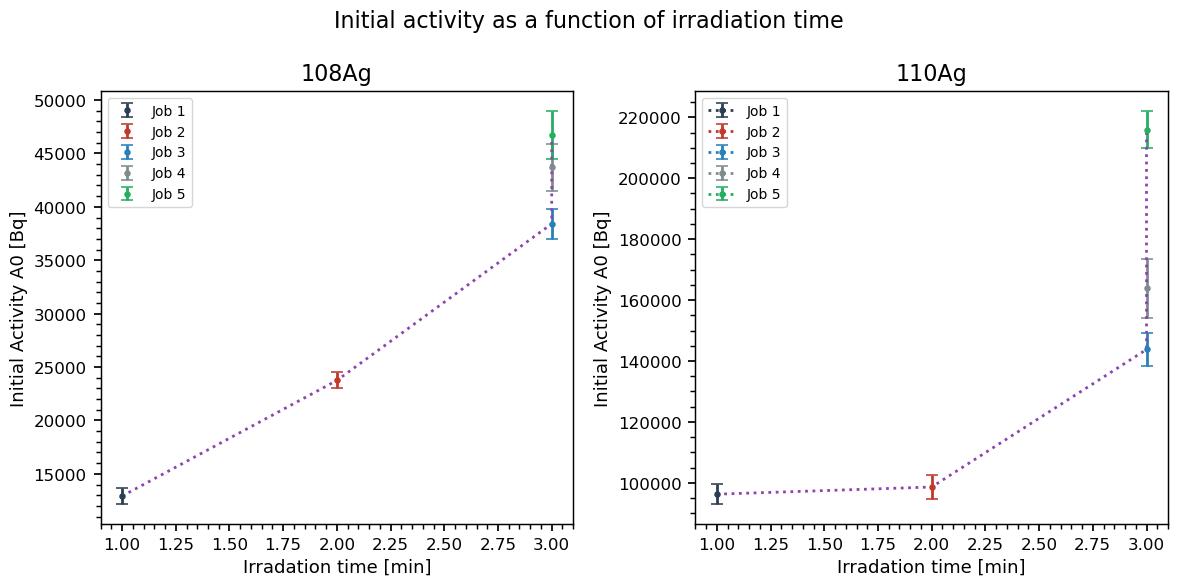

In [24]:
all_analyses = [analysis_1, analysis_2, analysis_3, analysis_4, analysis_5]
analysis_names = ['Job 1', 'Job 2', 'Job 3', 'Job 4', 'Job 5']
irradiation_times = [analysis.job_specs['irradiation_time'] for analysis in all_analyses]
A0_values_108 = [analysis.Ag108.A0.nominal_value for analysis in all_analyses]
A0_values_110 = [analysis.Ag110.A0.nominal_value for analysis in all_analyses]
A0_uncertainties_108 = [analysis.Ag108.A0.std_dev for analysis in all_analyses]
A0_uncertainties_110 = [analysis.Ag110.A0.std_dev for analysis in all_analyses] 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for irr, A0, A0_unc, job_number in zip(irradiation_times, A0_values_108, A0_uncertainties_108, analysis_names):
    plt.errorbar(irr, A0, yerr=A0_unc, fmt='o', label=job_number)
plt.plot(irradiation_times, A0_values_108, linestyle=':')

plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('108Ag')
plt.legend()

plt.subplot(1, 2, 2)
for irr, A0, A0_unc, job_number in zip(irradiation_times, A0_values_110, A0_uncertainties_110, analysis_names):
    plt.errorbar(irr, A0, yerr=A0_unc, marker='o', linestyle=':', label=job_number)
plt.plot(irradiation_times, A0_values_110, linestyle=':')
    
plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('110Ag')
plt.legend()

plt.suptitle('Initial activity as a function of irradiation time')
plt.tight_layout()
plt.savefig(fig_path / 'initial_activity_vs_irradiation_time.pdf')
plt.savefig(fig_path / 'initial_activity_vs_irradiation_time.png')
plt.show()

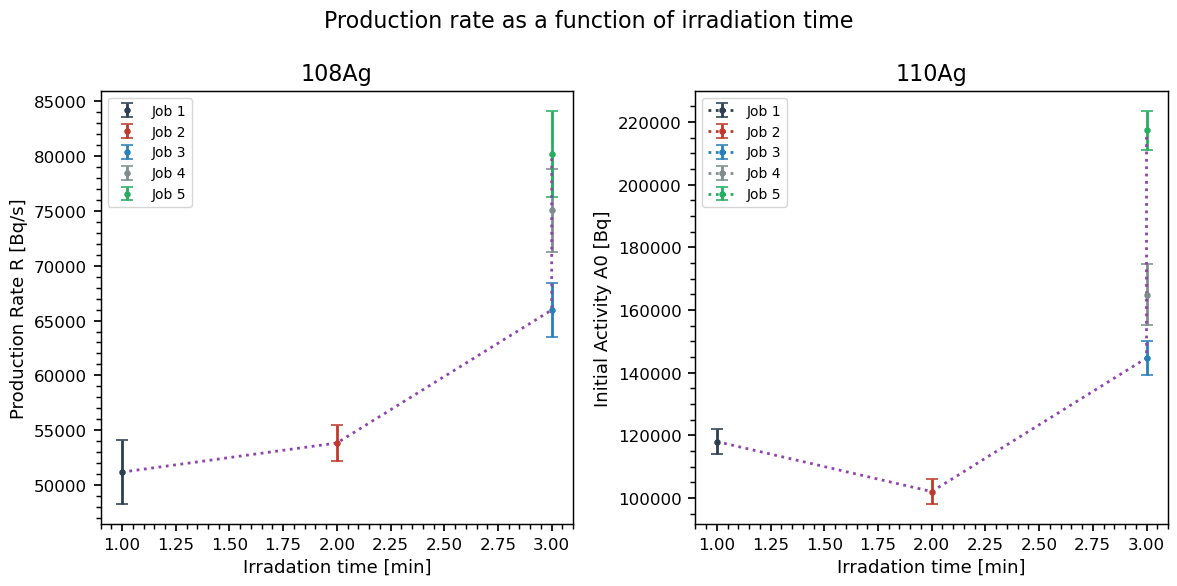

In [25]:
all_analyses = [analysis_1, analysis_2, analysis_3, analysis_4, analysis_5]
analysis_names = ['Job 1', 'Job 2', 'Job 3', 'Job 4', 'Job 5']
irradiation_times = [analysis.job_specs['irradiation_time'] for analysis in all_analyses]
A0_values_108 = [analysis.Ag108.A0.nominal_value for analysis in all_analyses]
A0_values_110 = [analysis.Ag110.A0.nominal_value for analysis in all_analyses]
A0_uncertainties_108 = [analysis.Ag108.A0.std_dev for analysis in all_analyses]
A0_uncertainties_110 = [analysis.Ag110.A0.std_dev for analysis in all_analyses] 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for irr, A0, A0_unc, job_number in zip(irradiation_times, A0_values_108, A0_uncertainties_108, analysis_names):
    λ = ci.Isotope('108AG').decay_const()
    R = A0 / (1 - np.exp(-λ * irr * 60))  # Convert minutes to seconds
    R_unc = A0_unc / (1 - np.exp(-λ * irr * 60))  # Uncertainty in production rate
    plt.errorbar(irr, R, yerr=R_unc, fmt='o', label=job_number)
plt.plot(irradiation_times, [A0 / (1 - np.exp(-λ * irr * 60)) for A0, irr in zip(A0_values_108, irradiation_times)], linestyle=':')

plt.xlabel('Irradation time [min]')
plt.ylabel('Production Rate R [Bq/s]')
plt.title('108Ag')
plt.legend()

plt.subplot(1, 2, 2)
for irr, A0, A0_unc, job_number in zip(irradiation_times, A0_values_110, A0_uncertainties_110, analysis_names):
    λ = ci.Isotope('110AG').decay_const()
    R = A0 / (1 - np.exp(-λ * irr * 60))  # Convert minutes to seconds
    R_unc = A0_unc / (1 - np.exp(-λ * irr * 60))  # Uncertainty in production rate
    plt.errorbar(irr, R, yerr=R_unc, marker='o', linestyle=':', label=job_number)
plt.plot(irradiation_times, [A0 / (1 - np.exp(-λ * irr * 60)) for A0, irr in zip(A0_values_110, irradiation_times)], linestyle=':')

plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('110Ag')
plt.legend()

plt.suptitle('Production rate as a function of irradiation time')
plt.tight_layout()
plt.savefig(fig_path / 'production_rate_vs_irradiation_time.pdf')
plt.savefig(fig_path / 'production_rate_vs_irradiation_time.png')
plt.show()

# Part 2:

## Possible Nuclides

### Target Nuclides

#### $^{\text{nat}}\text{Ge}$ (Germanium)

- nat Ga
- Target: 71 Ge
- Only 71 Ga can produce 71 Ge with proton beam
- Monitor foils: 
  - nat Ni
  - nat Cu

- 64,65,66,67,68,69,70,71,72 Ge
- 63,64,65,66,67,68,69,70,71 Ga
- 62,63,64,65,66,67,68,69,70 Zn 
- 61,62,63,64,65,66,67,68,69 Cu
- 60,61,62,63,64,65,66,67,68 Ni
- 59,60,61,62,63,64,65,66,67 Co 
- 58,59,60,61,62,63,64,65,66 Fe

| Atom name | Half-life | Observed | Not Observed | Maybe Observed |
| :---  | :--- | :--- | :--- | :--- |
| 72Ge  | Stable     | [ ] | [x] | [ ] | 
| 71Ge  | 11.42 d    | [x] | [ ] | [ ] | 
| 70Ge  | Stable     | [ ] | [x] | [ ] | 
| 69Ge  | 38.9 h     | [x] | [ ] | [ ] | 
| 68Ge  | 271.84 d   | [x] | [ ] | [ ] | 
| 67Ge  | 18.9 min   | [x] | [ ] | [ ] | 
| 66Ge  | 2.26 h     | [x] | [ ] | [ ] |
| 65Ge  | 30.8 s     | [ ] | [ ] | [x] |
| 64Ge  | 63.7 s     | [ ] | [ ] | [x] |
| 71Ga  | Stable     | [ ] | [x] | [ ] | 
| 70Ga  | 21.14 min  | [x] | [ ] | [ ] | 
| 69Ga  | Stable     | [ ] | [x] | [ ] |
| 68Ga  | 67.843 min | [x] | [ ] | [ ] | 
| 67Ga  | 3.26 d     | [x] | [ ] | [ ] | 
| 66Ga  | 9.304 h    | [x] | [ ] | [ ] | 
| 65Ga  | 15.134 min | [ ] | [ ] | [x] |
| 64Ga  | 2.627 min  | [ ] | [ ] | [x] |
| 63Ga  | 32.1 s     | [ ] | [ ] | [x] |
| 70Zn  | Stable     | [ ] | [x] | [ ] |
| 69Zn  | 56.4 min   | [x] | [ ] | [ ] |
| 68Zn  | Stable     | [ ] | [x] | [ ] |
| 67Zn  | Stable     | [ ] | [x] | [ ] | 
| 66Zn  | Stable     | [ ] | [x] | [ ] | 
| 65Zn  | 243.93 d   | [x] | [ ] | [ ] | 
| 64Zn  | Stable     | [ ] | [x] | [ ] |
| 63Zn  | 38.38 min  | [x] | [ ] | [ ] |
| 62Zn  | 9.193 h    | [x] | [ ] | [ ] | 
| 69Cu  | 2.9 min    | [ ] | [ ] | [x] | 
| 68Cu  | 30.8 s     | [ ] | [ ] | [x] | 
| 67Cu  | 61.81 h    | [x] | [ ] | [ ] | 
| 66Cu  | 5.09 min   | [ ] | [ ] | [x] |
| 65Cu  | Stable     | [ ] | [x] | [ ] | 
| 64Cu  | 12.70 h    | [x] | [ ] | [ ] |
| 63Cu  | Stable     | [ ] | [x] | [ ] |
| 62Cu  | 9.672 min  | [x] | [ ] | [ ] |
| 61Cu  | 3.339 min  | [ ] | [ ] | [x] | 
| 68Ni  | 29 s       | [ ] | [ ] | [x] |
| 67Ni  | 21 s       | [ ] | [ ] | [x] |
| 66Ni  | 54.6 h     | [x] | [ ] | [ ] |
| 65Ni  | 2.52 h     | [x] | [ ] | [ ] |
| 64Ni  | Stable     | [ ] | [x] | [ ] |
| 63Ni  | 100.8 y    | [x] | [ ] | [ ] |
| 62Ni  | Stable     | [ ] | [x] | [ ] |
| 61Ni  | Stable     | [ ] | [x] | [ ] |
| 60Ni  | Stable     | [ ] | [x] | [ ] |
| 67Co  | 329 ms     | [ ] | [x] | [ ] |
| 66Co  | 200 ms     | [ ] | [x] | [ ] |
| 65Co  | 1.16 s     | [ ] | [x] | [ ] |
| 64Co  | 300 ms     | [ ] | [x] | [ ] |
| 63Co  | 26.9 s     | [ ] | [ ] | [x] |
| 62Co  | 1.51 min   | [ ] | [ ] | [x] |
| 61Co  | 1.65 h     | [x] | [ ] | [ ] |
| 60Co  | 5.271 y    | [x] | [ ] | [ ] |
| 59Co  | Stable     | [ ] | [x] | [ ] |
| 66Fe  | 472 ms     | [ ] | [x] | [ ] |
| 65Fe  | 0.803 s    | [ ] | [x] | [ ] |
| 64Fe  | 2.0 s      | [ ] | [x] | [ ] |
| 63Fe  | 6.1 s      | [ ] | [x] | [ ] |
| 62Fe  | 68 s       | [ ] | [ ] | [x] |
| 61Fe  | 6.03 min   | [ ] | [ ] | [x] |
| 60Fe  | 2.61e6 y   | [ ] | [x] | [ ] |
| 59Fe  | 44.495 d   | [x] | [ ] | [ ] |
| 58Fe  | Stable     | [x] | [ ] | [ ] |

In [183]:
def print_isotope_half_lives(isotopes_str):
    isotopes = {}
    
    isotope_list = isotopes_str.strip().split()
    for iso_name in isotope_list:
        try:
            iso = ci.Isotope(iso_name.upper())
            hl_s = iso.half_life('s')

            if hl_s is None:
                print(f"{iso_name}: No half-life data available")
                continue
            
            elif hl_s < 1:
                unit = 'ms'
                hl = iso.half_life(unit)
            
            elif hl_s < 60: # less than a minute
                unit = 's'
                hl = hl_s
            
            elif hl_s < 60 * 60: # less than an hour
                unit = 'min'
                hl = iso.half_life(unit)
                
            elif hl_s < 24 * 60 * 60: # less than a day
                unit = 'h'
                hl = iso.half_life(unit)
            
            elif hl_s < 365 * 24 * 60 * 60: # less than a year
                unit = 'd'
                hl = iso.half_life(unit)
                
            elif hl_s < np.inf:
                unit = 'y'
                hl = iso.half_life(unit)
                
            elif hl_s == np.inf:
                hl = 'Stable'
                unit = ''
            
            else:
                raise ValueError(f"Unexpected half-life value for {iso_name}: {hl_s} seconds")
                
            
            isotopes[iso_name] = f'{hl} {unit}' if hl != 'Stable' else 'Stable'
            print(f"{iso_name}: {hl:.4g} {unit}") if hl != 'Stable' else print(f"{iso_name}: Stable")
                
        except Exception as e:
            print(f"Could not process {iso_name}: {e}")
            
    return isotopes

#Use the dictionary `isotopes` above to create a markdown table just like the table above.
def create_markdown_table(isotopes: dict[str, str]) -> str:
    markdown_table = "| Isotope | Half-life  | Observed | Not Observed | Maybe Observed |\n"
    markdown_table += "|---------|------------|----------|--------------|----------------|\n"
    for iso_name, hl in isotopes.items():
        if hl == 'Stable':
            observed = '[ ]'
            not_observed = '[x]'
            maybe_observed = '[ ]'
            val = 'Stable'
            continue
        
        val, unit = hl.split()
        cond1 = unit == 'ms'  
        cond2 = unit == 's' and float(val) < 60
        cond3 = unit == 'y' and float(val) > 100 
        cond4 = unit == 'min' and float(val) < 10     
        if cond1 or cond2 or cond3:
            observed = '[ ]'
            not_observed = '[x]'
            maybe_observed = '[ ]'
            val = f'{float(val):.4g} {unit}'

        elif cond4:
            observed = '[ ]'
            not_observed = '[ ]'
            maybe_observed = '[x]'
            val = f'{float(val):.4g} {unit}'
        
        else:
            observed = '[?]'
            not_observed = '[ ]'
            maybe_observed = '[ ]'
            val = f'{float(val):.4g} {unit}'

        markdown_table += f"| {iso_name:<7} | {val:<10} | {observed:<8} | {not_observed:<12} | {maybe_observed:<14} |\n"
    
    return markdown_table

def fix_iso_name(name: str) -> str:
    """
    Converts isotope names from the format '108AG' to 'Ag108'.
    """ 
    numbers_part = ''.join(filter(str.isdigit, name))
    letters_part = ''.join(filter(str.isalpha, name)).capitalize()
    return f"{letters_part}{numbers_part}"


def get_interesting_isotopes(isotopes: dict[str, str]) -> tuple[list[str]]:
    """
    Returns two list of isotopes:
    - `observed`: isotopes that are observed in the spectrum.
    - `maybe_observed`: isotopes that are maybe observed in the spectrum.
    """
    observed = []
    maybe_observed = []
    
    for iso, hl in isotopes.items():
        val, unit = hl.split() if hl != 'Stable' else ('Stable', '')
        cond1 = val == 'Stable' # Won't be observed  
        cond2 = unit == 'ms'  # Too short half-life to be observed
        cond3 = unit == 's'  # Too short half-life to be observed
        cond4 = unit == 'y' and float(val) > 100 # Too long half-life to be observed
        cond5 = unit == 'min' and float(val) < 10  # Might be observed, but unlikely
        
        if cond1 or cond2 or cond3 or cond4:
            continue
        
        elif cond5:
            maybe_observed.append(fix_iso_name(iso))
        else:
            observed.append(fix_iso_name(iso))
            
    return observed, maybe_observed

#### $^{\text{nat}}\text{Sn}$ (Tin)

- 107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125 Sb
- 106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124 Sn 
- 105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123 In  
- 104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122 Cd 
- 103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121 Ag
- 102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120 Pd
- 101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119 Rh
- 100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118 Ru

In [184]:
isotope_str_Sn = """ 
125Sb 124Sb 123Sb 122Sb 121Sb 120Sb 119Sb 118Sb 117Sb 116Sb 115Sb 114Sb 113Sb 112Sb 111Sb 110Sb 109Sb 108Sb 107Sb
124Sn 123Sn 122Sn 121Sn 120Sn 119Sn 118Sn 117Sn 116Sn 115Sn 114Sn 113Sn 112Sn 111Sn 110Sn 109Sn 108Sn 107Sn 106Sn
123In 122In 121In 120In 119In 118In 117In 116In 115In 114In 113In 112In 111In 110In 109In 108In 107In 106In 105In
122Cd 121Cd 120Cd 119Cd 118Cd 117Cd 116Cd 115Cd 114Cd 113Cd 112Cd 111Cd 110Cd 109Cd 108Cd 107Cd 106Cd 105Cd 104Cd
121Ag 120Ag 119Ag 118Ag 117Ag 116Ag 115Ag 114Ag 113Ag 112Ag 111Ag 110Ag 109Ag 108Ag 107Ag 106Ag 105Ag 104Ag 103Ag
120Pd 119Pd 118Pd 117Pd 116Pd 115Pd 114Pd 113Pd 112Pd 111Pd 110Pd 109Pd 108Pd 107Pd 106Pd 105Pd 104Pd 103Pd 102Pd
119Rh 118Rh 117Rh 116Rh 115Rh 114Rh 113Rh 112Rh 111Rh 110Rh 109Rh 108Rh 107Rh 106Rh 105Rh 104Rh 103Rh 102Rh 101Rh
118Ru 117Ru 116Ru 115Ru 114Ru 113Ru 112Ru 111Ru 110Ru 109Ru 108Ru 107Ru 106Ru 105Ru 104Ru 103Ru 102Ru 101Ru 100Ru
"""

isotopes_half_lives_Sn = print_isotope_half_lives(isotope_str_Sn)

125Sb: 2.759 y
124Sb: 60.2 d
123Sb: Stable
122Sb: 2.724 d
121Sb: Stable
120Sb: 15.89 min
119Sb: 1.591 d
118Sb: 3.6 min
117Sb: 2.8 h
116Sb: 15.8 min
115Sb: 32.1 min
114Sb: 3.49 min
113Sb: 6.67 min
112Sb: 51.4 s
111Sb: 1.25 min
110Sb: 23 s
109Sb: 17 s
108Sb: 7.4 s
107Sb: 4 s
124Sn: Stable
123Sn: 129.2 d
122Sn: Stable
121Sn: 1.126 d
120Sn: Stable
119Sn: Stable
118Sn: Stable
117Sn: Stable
116Sn: Stable
115Sn: Stable
114Sn: Stable
113Sn: 115.1 d
112Sn: Stable
111Sn: 35.3 min
110Sn: 4.11 h
109Sn: 18 min
108Sn: 10.3 min
107Sn: 2.9 min
106Sn: 1.917 min
123In: 6.17 s
122In: 1.5 s
121In: 23.1 s
120In: 3.08 s
119In: 2.4 min
118In: 5 s
117In: 43.2 min
116In: 14.1 s
115In: 4.41e+14 y
114In: 1.198 min
113In: Stable
112In: 14.97 min
111In: 2.805 d
110In: 4.9 h
109In: 4.167 h
108In: 58 min
107In: 32.4 min
106In: 6.2 min
105In: 5.07 min
122Cd: 5.24 s
121Cd: 13.5 s
120Cd: 50.8 s
119Cd: 2.69 min
118Cd: 50.3 min
117Cd: 2.49 h
116Cd: 3.1e+19 y
115Cd: 2.228 d
114Cd: Stable
113Cd: 8.04e+15 y
112Cd: Stable
11

In [185]:
markdown_table_Sn = create_markdown_table(isotopes_half_lives_Sn)
print(markdown_table_Sn)

| Isotope | Half-life  | Observed | Not Observed | Maybe Observed |
|---------|------------|----------|--------------|----------------|
| 125Sb   | 2.759 y    | [?]      | [ ]          | [ ]            |
| 124Sb   | 60.2 d     | [?]      | [ ]          | [ ]            |
| 122Sb   | 2.724 d    | [?]      | [ ]          | [ ]            |
| 120Sb   | 15.89 min  | [?]      | [ ]          | [ ]            |
| 119Sb   | 1.591 d    | [?]      | [ ]          | [ ]            |
| 118Sb   | 3.6 min    | [ ]      | [ ]          | [x]            |
| 117Sb   | 2.8 h      | [?]      | [ ]          | [ ]            |
| 116Sb   | 15.8 min   | [?]      | [ ]          | [ ]            |
| 115Sb   | 32.1 min   | [?]      | [ ]          | [ ]            |
| 114Sb   | 3.49 min   | [ ]      | [ ]          | [x]            |
| 113Sb   | 6.67 min   | [ ]      | [ ]          | [x]            |
| 112Sb   | 51.4 s     | [ ]      | [x]          | [ ]            |
| 111Sb   | 1.25 min   | [ ]      | [ ]         

In [187]:
observed_Sn, maybe_observed_Sn = get_interesting_isotopes(isotopes_half_lives_Sn)

print(f'Observed {len(observed_Sn)} isotopes: {", ".join(observed_Sn)}')
print(f'Maybe observed {len(maybe_observed_Sn)} isotopes: {", ".join(maybe_observed_Sn)}')

Observed 48 isotopes: Sb125, Sb124, Sb122, Sb120, Sb119, Sb117, Sb116, Sb115, Sn123, Sn121, Sn113, Sn111, Sn110, Sn109, Sn108, In117, In112, In111, In110, In109, In108, In107, Cd118, Cd117, Cd115, Cd109, Cd107, Cd105, Cd104, Ag115, Ag113, Ag112, Ag111, Ag106, Ag105, Ag104, Ag103, Pd112, Pd111, Pd109, Pd103, Rh107, Rh105, Rh102, Rh101, Ru106, Ru105, Ru103
Maybe observed 19 isotopes: Sb118, Sb114, Sb113, Sb111, Sn107, Sn106, In119, In114, In106, In105, Cd119, Ag117, Ag116, Ag108, Pd114, Pd113, Rh109, Ru108, Ru107


### Monitor Foils

#### $^{\text{nat}}\text{Cu}$ (Copper)

- 58,59,60,61,62,63,64,65,66 Zn
- 57,58,59,60,61,62,63,64,65 Cu
- 56,57,58,59,60,61,62,63,64 Ni 
- 55,56,57,58,59,60,61,62,63 Co
- 54,55,56,57,58,59,60,61,62 Fe
- 53,54,55,56,57,58,59,60,61 Mn
- 52,53,54,55,56,57,58,59,60 Cr

In [ ]:
import curie as ci

isotopes_str_Cu = """
66Zn 65Zn 64Zn 63Zn 62Zn 61Zn 60Zn 59Zn 58Zn
65Cu 64Cu 63Cu 62Cu 61Cu 60Cu 59Cu 58Cu 57Cu
64Ni 63Ni 62Ni 61Ni 60Ni 59Ni 58Ni 57Ni 56Ni
63Co 62Co 61Co 60Co 59Co 58Co 57Co 56Co 55Co
62Fe 61Fe 60Fe 59Fe 58Fe 57Fe 56Fe 55Fe 54Fe
61Mn 60Mn 59Mn 58Mn 57Mn 56Mn 55Mn 54Mn 53Mn
60Cr 59Cr 58Cr 57Cr 56Cr 55Cr 54Cr 53Cr 52Cr
"""


isotopes_half_lives_Cu = print_isotope_half_lives(isotopes_str_Cu)

66Zn: Stable
65Zn: 243.9 d
64Zn: Stable
63Zn: 38.47 min
62Zn: 9.26 h
61Zn: 1.485 min
60Zn: 2.38 min
59Zn: 182 ms
58Zn: 84 ms
65Cu: Stable
64Cu: 12.7 h
63Cu: Stable
62Cu: 9.673 min
61Cu: 3.333 h
60Cu: 23.7 min
59Cu: 1.358 min
58Cu: 3.204 s
57Cu: 196.3 ms
64Ni: Stable
63Ni: 101.2 y
62Ni: Stable
61Ni: Stable
60Ni: Stable
59Ni: 7.6e+04 y
58Ni: Stable
57Ni: 1.483 d
56Ni: 6.075 d
63Co: 27.4 s
62Co: 1.5 min
61Co: 1.65 h
60Co: 5.271 y
59Co: Stable
58Co: 70.86 d
57Co: 271.7 d
56Co: 77.23 d
55Co: 17.53 h
62Fe: 1.133 min
61Fe: 5.98 min
60Fe: 1.5e+06 y
59Fe: 44.49 d
58Fe: Stable
57Fe: Stable
56Fe: Stable
55Fe: 2.744 y
54Fe: Stable
61Mn: 670 ms
60Mn: 51 s
59Mn: 4.59 s
58Mn: 3 s
57Mn: 1.423 min
56Mn: 2.579 h
55Mn: Stable
54Mn: 312.1 d
53Mn: 3.7e+06 y
60Cr: 490 ms
59Cr: 460 ms
58Cr: 7 s
57Cr: 21.1 s
56Cr: 5.94 min
55Cr: 3.497 min
54Cr: Stable
53Cr: Stable
52Cr: Stable


In [92]:
import pyperclip as pc

markdown_table_Cu = create_markdown_table(isotopes_half_lives_Cu)
print(markdown_table_Cu)
pc.copy(markdown_table_Cu)

| Isotope | Half-life | Observed | Not Observed | Maybe Observed |
|---------|-----------|----------|--------------|----------------|
| 66Zn    | Stable    | [ ]      | [x]          | [ ]            |
| 65Zn    | 243.9 d   | [?]      | [ ]          | [ ]            |
| 64Zn    | Stable    | [ ]      | [x]          | [ ]            |
| 63Zn    | 38.47 min | [?]      | [ ]          | [ ]            |
| 62Zn    | 9.26 h    | [?]      | [ ]          | [ ]            |
| 61Zn    | 1.485 min | [ ]      | [ ]          | [x]            |
| 60Zn    | 2.38 min  | [ ]      | [ ]          | [x]            |
| 59Zn    | 182 ms    | [ ]      | [x]          | [ ]            |
| 58Zn    | 84 ms     | [ ]      | [x]          | [ ]            |
| 65Cu    | Stable    | [ ]      | [x]          | [ ]            |
| 64Cu    | 12.7 h    | [?]      | [ ]          | [ ]            |
| 63Cu    | Stable    | [ ]      | [x]          | [ ]            |
| 62Cu    | 9.673 min | [ ]      | [ ]          | [x]         

| Isotope | Half-life | Observed | Not Observed | Maybe Observed |
|:--------|:----------|:---------|:-------------|:---------------|
| 66Zn    | Stable    | [ ]      | [x]          | [ ]            |
| 65Zn    | 243.9 d   | [x]      | [ ]          | [ ]            |
| 64Zn    | Stable    | [ ]      | [x]          | [ ]            |
| 63Zn    | 38.47 min | [x]      | [ ]          | [ ]            |
| 62Zn    | 9.26 h    | [x]      | [ ]          | [ ]            |
| 61Zn    | 1.485 min | [ ]      | [ ]          | [x]            |
| 60Zn    | 2.38 min  | [ ]      | [ ]          | [x]            |
| 59Zn    | 182 ms    | [ ]      | [x]          | [ ]            |
| 58Zn    | 84 ms     | [ ]      | [x]          | [ ]            |
| 65Cu    | Stable    | [ ]      | [x]          | [ ]            |
| 64Cu    | 12.7 h    | [x]      | [ ]          | [ ]            |
| 63Cu    | Stable    | [ ]      | [x]          | [ ]            |
| 62Cu    | 9.673 min | [x]      | [ ]          | [ ]            |
| 61Cu    | 3.333 h   | [x]      | [ ]          | [ ]            |
| 60Cu    | 23.7 min  | [x]      | [ ]          | [ ]            |
| 59Cu    | 1.358 min | [ ]      | [ ]          | [x]            |
| 58Cu    | 3.204 s   | [ ]      | [x]          | [ ]            |
| 57Cu    | 196.3 ms  | [ ]      | [x]          | [ ]            |
| 64Ni    | Stable    | [ ]      | [x]          | [ ]            |
| 63Ni    | 101.2 y   | [x]      | [ ]          | [ ]            |
| 62Ni    | Stable    | [ ]      | [x]          | [ ]            |
| 61Ni    | Stable    | [ ]      | [x]          | [ ]            |
| 60Ni    | Stable    | [ ]      | [x]          | [ ]            |
| 59Ni    | 7.6e+04 y | [ ]      | [x]          | [ ]            |
| 58Ni    | Stable    | [ ]      | [x]          | [ ]            |
| 57Ni    | 1.483 d   | [x]      | [ ]          | [ ]            |
| 56Ni    | 6.075 d   | [x]      | [ ]          | [ ]            |
| 63Co    | 27.4 s    | [ ]      | [ ]          | [x]            |
| 62Co    | 1.5 min   | [ ]      | [ ]          | [x]            |
| 61Co    | 1.65 h    | [x]      | [ ]          | [ ]            |
| 60Co    | 5.271 y   | [x]      | [ ]          | [ ]            |
| 59Co    | Stable    | [ ]      | [x]          | [ ]            |
| 58Co    | 70.86 d   | [x]      | [ ]          | [ ]            |
| 57Co    | 271.7 d   | [x]      | [ ]          | [ ]            |
| 56Co    | 77.23 d   | [x]      | [ ]          | [ ]            |
| 55Co    | 17.53 h   | [x]      | [ ]          | [ ]            |
| 62Fe    | 1.133 min | [ ]      | [ ]          | [x]            |
| 61Fe    | 5.98 min  | [ ]      | [ ]          | [x]            |
| 60Fe    | 1.5e+06 y | [ ]      | [x]          | [ ]            |
| 59Fe    | 44.49 d   | [x]      | [ ]          | [ ]            |
| 58Fe    | Stable    | [ ]      | [x]          | [ ]            |
| 57Fe    | Stable    | [ ]      | [x]          | [ ]            |
| 56Fe    | Stable    | [ ]      | [x]          | [ ]            |
| 55Fe    | 2.744 y   | [x]      | [ ]          | [ ]            |
| 54Fe    | Stable    | [ ]      | [x]          | [ ]            |
| 61Mn    | 670 ms    | [ ]      | [x]          | [ ]            |
| 60Mn    | 51 s      | [ ]      | [ ]          | [x]            |
| 59Mn    | 4.59 s    | [ ]      | [x]          | [ ]            |
| 58Mn    | 3 s       | [ ]      | [x]          | [ ]            |
| 57Mn    | 1.423 min | [ ]      | [ ]          | [x]            |
| 56Mn    | 2.579 h   | [x]      | [ ]          | [ ]            |
| 55Mn    | Stable    | [ ]      | [x]          | [ ]            |
| 54Mn    | 312.1 d   | [x]      | [ ]          | [ ]            |
| 53Mn    | 3.7e+06 y | [ ]      | [x]          | [ ]            |
| 60Cr    | 490 ms    | [ ]      | [x]          | [ ]            |
| 59Cr    | 460 ms    | [ ]      | [x]          | [ ]            |
| 58Cr    | 7 s       | [ ]      | [x]          | [ ]            |
| 57Cr    | 21.1 s    | [ ]      | [ ]          | [x]            |
| 56Cr    | 5.94 min  | [x]      | [ ]          | [ ]            |
| 55Cr    | 3.497 min | [ ]      | [ ]          | [x]            |
| 54Cr    | Stable    | [ ]      | [x]          | [ ]            |
| 53Cr    | Stable    | [ ]      | [x]          | [ ]            |
| 52Cr    | Stable    | [ ]      | [x]          | [ ]            |

#### $^{\text{nat}}\text{Ni}$ (Nickel)

- 53,54,55,56,57,58,59,60,61,62,63,64,65 Cu 
- 52,53,54,55,56,57,58,59,60,61,62,63,64 Ni 
- 51,52,53,54,55,56,57,58,59,60,61,62,63 Co
- 50,51,52,53,54,55,56,57,58,59,60,61,62 Fe
- 49,50,51,52,53,54,55,56,57,58,59,60,61 Mn 
- 48,49,50,51,52,53,54,55,56,57,58,59,60 Cr
- 47,48,49,50,51,52,53,54,55,56,57,58,59 V

In [97]:
isotopes_str_Ni = """
53Cu 54Cu 55Cu 56Cu 57Cu 58Cu 59Cu 60Cu 61Cu 62Cu 63Cu 64Cu 65Cu
52Ni 53Ni 54Ni 55Ni 56Ni 57Ni 58Ni 59Ni 60Ni 61Ni 62Ni 63Ni 64Ni
51Co 52Co 53Co 54Co 55Co 56Co 57Co 58Co 59Co 60Co 61Co 62Co 63Co
50Fe 51Fe 52Fe 53Fe 54Fe 55Fe 56Fe 57Fe 58Fe 59Fe 60Fe 61Fe 62Fe
49Mn 50Mn 51Mn 52Mn 53Mn 54Mn 55Mn 56Mn 57Mn 58Mn 59Mn 60Mn 61Mn
48Cr 49Cr 50Cr 51Cr 52Cr 53Cr 54Cr 55Cr 56Cr 57Cr 58Cr 59Cr 60Cr
47V 48V 49V 50V 51V 52V 53V 54V 55V 56V 57V 58V 59V
"""

isotopes_half_lives_Sn = print_isotope_half_lives(isotopes_str_Ni)

53Cu: 0.0003 ms
54Cu: 7.5e-05 ms
55Cu: 40 ms
56Cu: 94 ms
57Cu: 196.3 ms
58Cu: 3.204 s
59Cu: 1.358 min
60Cu: 23.7 min
61Cu: 3.333 h
62Cu: 9.673 min
63Cu: Stable
64Cu: 12.7 h
65Cu: Stable
52Ni: 38 ms
53Ni: 45 ms
54Ni: 104 ms
55Ni: 204.7 ms
56Ni: 6.075 d
57Ni: 1.483 d
58Ni: Stable
59Ni: 7.6e+04 y
60Ni: Stable
61Ni: Stable
62Ni: Stable
63Ni: 101.2 y
64Ni: Stable
51Co: 0.0002 ms
52Co: 115 ms
53Co: 240 ms
54Co: 193.3 ms
55Co: 17.53 h
56Co: 77.23 d
57Co: 271.7 d
58Co: 70.86 d
59Co: Stable
60Co: 5.271 y
61Co: 1.65 h
62Co: 1.5 min
63Co: 27.4 s
50Fe: 155 ms
51Fe: 305 ms
52Fe: 8.275 h
53Fe: 8.51 min
54Fe: Stable
55Fe: 2.744 y
56Fe: Stable
57Fe: Stable
58Fe: Stable
59Fe: 44.49 d
60Fe: 1.5e+06 y
61Fe: 5.98 min
62Fe: 1.133 min
49Mn: 382 ms
50Mn: 283.2 ms
51Mn: 46.2 min
52Mn: 5.591 d
53Mn: 3.7e+06 y
54Mn: 312.1 d
55Mn: Stable
56Mn: 2.579 h
57Mn: 1.423 min
58Mn: 3 s
59Mn: 4.59 s
60Mn: 51 s
61Mn: 670 ms
48Cr: 21.56 h
49Cr: 42.3 min
50Cr: Stable
51Cr: 27.7 d
52Cr: Stable
53Cr: Stable
54Cr: Stable
55Cr: 

In [98]:
markdown_table_Ni = create_markdown_table(isotopes_half_lives_Sn)
print(markdown_table_Ni)
pc.copy(markdown_table_Ni)

| Isotope | Half-life | Observed | Not Observed | Maybe Observed |
|---------|-----------|----------|--------------|----------------|
| 53Cu    | 0.0003 ms | [ ]      | [x]          | [ ]            |
| 54Cu    | 7.5e-05 ms | [ ]      | [x]          | [ ]            |
| 55Cu    | 40 ms     | [ ]      | [x]          | [ ]            |
| 56Cu    | 94 ms     | [ ]      | [x]          | [ ]            |
| 57Cu    | 196.3 ms  | [ ]      | [x]          | [ ]            |
| 58Cu    | 3.204 s   | [ ]      | [x]          | [ ]            |
| 59Cu    | 1.358 min | [ ]      | [ ]          | [x]            |
| 60Cu    | 23.7 min  | [?]      | [ ]          | [ ]            |
| 61Cu    | 3.333 h   | [?]      | [ ]          | [ ]            |
| 62Cu    | 9.673 min | [ ]      | [ ]          | [x]            |
| 63Cu    | Stable    | [ ]      | [x]          | [ ]            |
| 64Cu    | 12.7 h    | [?]      | [ ]          | [ ]            |
| 65Cu    | Stable    | [ ]      | [x]          | [ ]        

| Isotope | Half-life  | Observed | Not Observed | Maybe Observed |
|---------|------------|----------|--------------|----------------|
| 53Cu    | 0.0003 ms  | [ ]      | [x]          | [ ]            |
| 54Cu    | 7.5e-05 ms | [ ]      | [x]          | [ ]            |
| 55Cu    | 40 ms      | [ ]      | [x]          | [ ]            |
| 56Cu    | 94 ms      | [ ]      | [x]          | [ ]            |
| 57Cu    | 196.3 ms   | [ ]      | [x]          | [ ]            |
| 58Cu    | 3.204 s    | [ ]      | [x]          | [ ]            |
| 59Cu    | 1.358 min  | [ ]      | [ ]          | [x]            |
| 60Cu    | 23.7 min   | [x]      | [ ]          | [ ]            |
| 61Cu    | 3.333 h    | [x]      | [ ]          | [ ]            |
| 62Cu    | 9.673 min  | [x]      | [ ]          | [ ]            |
| 63Cu    | Stable     | [ ]      | [x]          | [ ]            |
| 64Cu    | 12.7 h     | [x]      | [ ]          | [ ]            |
| 65Cu    | Stable     | [ ]      | [x]          | [ ]            |
| 52Ni    | 38 ms      | [ ]      | [x]          | [ ]            |
| 53Ni    | 45 ms      | [ ]      | [x]          | [ ]            |
| 54Ni    | 104 ms     | [ ]      | [x]          | [ ]            |
| 55Ni    | 204.7 ms   | [ ]      | [x]          | [ ]            |
| 56Ni    | 6.075 d    | [x]      | [ ]          | [ ]            |
| 57Ni    | 1.483 d    | [x]      | [ ]          | [ ]            |
| 58Ni    | Stable     | [ ]      | [x]          | [ ]            |
| 59Ni    | 7.6e+04 y  | [ ]      | [x]          | [ ]            |
| 60Ni    | Stable     | [ ]      | [x]          | [ ]            |
| 61Ni    | Stable     | [ ]      | [x]          | [ ]            |
| 62Ni    | Stable     | [ ]      | [x]          | [ ]            |
| 63Ni    | 101.2 y    | [ ]      | [x]          | [ ]            |
| 64Ni    | Stable     | [ ]      | [x]          | [ ]            |
| 51Co    | 0.0002 ms  | [ ]      | [x]          | [ ]            |
| 52Co    | 115 ms     | [ ]      | [x]          | [ ]            |
| 53Co    | 240 ms     | [ ]      | [x]          | [ ]            |
| 54Co    | 193.3 ms   | [ ]      | [x]          | [ ]            |
| 55Co    | 17.53 h    | [x]      | [ ]          | [ ]            |
| 56Co    | 77.23 d    | [x]      | [ ]          | [ ]            |
| 57Co    | 271.7 d    | [x]      | [ ]          | [ ]            |
| 58Co    | 70.86 d    | [x]      | [ ]          | [ ]            |
| 59Co    | Stable     | [ ]      | [x]          | [ ]            |
| 60Co    | 5.271 y    | [x]      | [ ]          | [ ]            |
| 61Co    | 1.65 h     | [x]      | [ ]          | [ ]            |
| 62Co    | 1.5 min    | [ ]      | [ ]          | [x]            |
| 63Co    | 27.4 s     | [ ]      | [ ]          | [x]            |
| 50Fe    | 155 ms     | [ ]      | [x]          | [ ]            |
| 51Fe    | 305 ms     | [ ]      | [x]          | [ ]            |
| 52Fe    | 8.275 h    | [x]      | [ ]          | [ ]            |
| 53Fe    | 8.51 min   | [x]      | [ ]          | [ ]            |
| 54Fe    | Stable     | [ ]      | [x]          | [ ]            |
| 55Fe    | 2.744 y    | [x]      | [ ]          | [ ]            |
| 56Fe    | Stable     | [ ]      | [x]          | [ ]            |
| 57Fe    | Stable     | [ ]      | [x]          | [ ]            |
| 58Fe    | Stable     | [ ]      | [x]          | [ ]            |
| 59Fe    | 44.49 d    | [x]      | [ ]          | [ ]            |
| 60Fe    | 1.5e+06 y  | [ ]      | [x]          | [ ]            |
| 61Fe    | 5.98 min   | [x]      | [ ]          | [ ]            |
| 62Fe    | 1.133 min  | [ ]      | [ ]          | [x]            |
| 49Mn    | 382 ms     | [ ]      | [x]          | [ ]            |
| 50Mn    | 283.2 ms   | [ ]      | [x]          | [ ]            |
| 51Mn    | 46.2 min   | [x]      | [ ]          | [ ]            |
| 52Mn    | 5.591 d    | [x]      | [ ]          | [ ]            |
| 53Mn    | 3.7e+06 y  | [ ]      | [x]          | [ ]            |
| 54Mn    | 312.1 d    | [x]      | [ ]          | [ ]            |
| 55Mn    | Stable     | [ ]      | [x]          | [ ]            |
| 56Mn    | 2.579 h    | [x]      | [ ]          | [ ]            |
| 57Mn    | 1.423 min  | [ ]      | [ ]          | [x]            |
| 58Mn    | 3 s        | [ ]      | [x]          | [ ]            |
| 59Mn    | 4.59 s     | [ ]      | [x]          | [ ]            |
| 60Mn    | 51 s       | [ ]      | [x]          | [ ]            |
| 61Mn    | 670 ms     | [ ]      | [x]          | [ ]            |
| 48Cr    | 21.56 h    | [x]      | [ ]          | [ ]            |
| 49Cr    | 42.3 min   | [x]      | [ ]          | [ ]            |
| 50Cr    | Stable     | [ ]      | [x]          | [ ]            |
| 51Cr    | 27.7 d     | [x]      | [ ]          | [ ]            |
| 52Cr    | Stable     | [ ]      | [x]          | [ ]            |
| 53Cr    | Stable     | [ ]      | [x]          | [ ]            |
| 54Cr    | Stable     | [ ]      | [x]          | [ ]            |
| 55Cr    | 3.497 min  | [ ]      | [ ]          | [x]            |
| 56Cr    | 5.94 min   | [x]      | [ ]          | [ ]            |
| 57Cr    | 21.1 s     | [ ]      | [x]          | [ ]            |
| 58Cr    | 7 s        | [ ]      | [x]          | [ ]            |
| 59Cr    | 460 ms     | [ ]      | [x]          | [ ]            |
| 60Cr    | 490 ms     | [ ]      | [x]          | [ ]            |
| 47V     | 32.6 min   | [x]      | [ ]          | [ ]            |
| 48V     | 15.97 d    | [x]      | [ ]          | [ ]            |
| 49V     | 330 d      | [x]      | [ ]          | [ ]            |
| 50V     | 1.4e+17 y  | [ ]      | [x]          | [ ]            |
| 51V     | Stable     | [ ]      | [x]          | [ ]            |
| 52V     | 3.743 min  | [ ]      | [ ]          | [x]            |
| 53V     | 1.543 min  | [ ]      | [ ]          | [x]            |
| 54V     | 49.8 s     | [ ]      | [x]          | [ ]            |
| 55V     | 6.54 s     | [ ]      | [x]          | [ ]            |
| 56V     | 216 ms     | [ ]      | [x]          | [ ]            |
| 57V     | 350 ms     | [ ]      | [x]          | [ ]            |
| 58V     | 185 ms     | [ ]      | [x]          | [ ]            |
| 59V     | 75 ms      | [ ]      | [x]          | [ ]            |

In [104]:
observed_Cu, maybe_observed_Cu = get_interesting_isotopes(isotopes_half_lives_Cu)

print(f'Observed {len(observed_Cu)} isotopes in Cu spectrum: {observed_Cu}')
print(f'Maybe observed {len(maybe_observed_Cu)} isotopes in Cu spectrum: {maybe_observed_Cu}')

Observed 18 isotopes in Cu spectrum: ['Zn65', 'Zn63', 'Zn62', 'Cu64', 'Cu61', 'Cu60', 'Ni57', 'Ni56', 'Co61', 'Co60', 'Co58', 'Co57', 'Co56', 'Co55', 'Fe59', 'Fe55', 'Mn56', 'Mn54']
Maybe observed 10 isotopes in Cu spectrum: ['Zn61', 'Zn60', 'Cu62', 'Cu59', 'Co62', 'Fe62', 'Fe61', 'Mn57', 'Cr56', 'Cr55']


In [105]:
observed_Ni, maybe_observed_Ni = get_interesting_isotopes(isotopes_half_lives_Sn)

print(f'Observed {len(observed_Ni)} isotopes in Ni spectrum: {observed_Ni}')
print(f'Maybe observed {len(maybe_observed_Ni)} isotopes in Ni spectrum: {maybe_observed_Ni}')

Observed 24 isotopes in Ni spectrum: ['Cu60', 'Cu61', 'Cu64', 'Ni56', 'Ni57', 'Co55', 'Co56', 'Co57', 'Co58', 'Co60', 'Co61', 'Fe52', 'Fe55', 'Fe59', 'Mn51', 'Mn52', 'Mn54', 'Mn56', 'Cr48', 'Cr49', 'Cr51', 'V47', 'V48', 'V49']
Maybe observed 11 isotopes in Ni spectrum: ['Cu59', 'Cu62', 'Co62', 'Fe53', 'Fe61', 'Fe62', 'Mn57', 'Cr55', 'Cr56', 'V52', 'V53']


In [2]:
from tools import *

import numpy as np
import requests
import matplotlib.pyplot as plt
from urllib.request import urlopen

class Tendl:
    def __init__(self, target, beamParticle):
        self.target = target # target = {"Ir191": 0.373, "Ir193": 0.627}
        self.beamParticle = beamParticle

    def tendlDeuteronData(self, productZ, productA, isomerLevel = None):
        targetFoil = list(self.target.keys())[0][0:2]
        product = self.product(productZ, productA)
        fileEnding = self.tendlFileEnding(isomerLevel)
        E = []
        Cs = []
        for t in self.target.keys():
            data = self.retrieveTendlDataFromUrl(
                self.tendDeuteronlUrl(targetFoil, t, product, fileEnding), t

            )
            if isinstance(data[0], np.ndarray):
                E.append(data[0])
                Cs.append(data[1])

        if len(E)==0 or len(Cs)==0:
            "TENDL: No data found for target: " + targetFoil + " for productZ" + productZ + "and product A: " + productA
            raise Exception

        CsSummed = sum(Cs)
        E = E[0]
        E, Cs = Tools().interpolate(E, CsSummed)
        return E, Cs

 

    def tendlData(self, productZ, productA, isomerLevel=None, Elimit=None):
        targetFoil = list(self.target.keys())[0][0:2]
        product = self.product(productZ, productA)
        fileEnding = self.tendlFileEnding(isomerLevel)
        E = []
        Cs = []
        for t in self.target.keys():
            data = self.retrieveTendlDataFromUrl(
                self.tendlUrl(targetFoil, t, product, fileEnding), t

            )
            if isinstance(data[0], np.ndarray):
                E.append(data[0])
                Cs.append(data[1])

        if len(E)==0 or len(Cs)==0:
            "TENDL: No data found for target: " + targetFoil + " for productZ" + productZ + "and product A: " + productA

            # raise Exception
        CsSummed = sum(Cs)
        E = E[0]
        # x, y, xlimit=None, zeroPadding=False
        print(Elimit)
        E, Cs = Tools().interpolate(x=E, y=CsSummed, xlimit=Elimit)
        return E, Cs


    def plotTendl23(self, productZ, productA, isomerLevel = None): #, feeding = None, branchingRatio = None, parentIsomerLevel = None):
        # try:
        E, Cs = self.tendlDeuteronData(productZ, productA, isomerLevel)
        # if feeding == 'beta+' or feeding == 'beta-':
            # CsParent = self.correctForFeeding(productZ, productA, feeding, branchingRatio, parentIsomerLevel)[1]
            # Cs = Cs + CsParent
        plt.plot(E, Cs, label='TENDL-2023', linestyle='--', color='blue')

    # except:
        # print("Unable to retrive tendl data, perhaps no internet connection?")

    def plotTendl23Unique(self, productZ, productA, isomerLevel = None, color=None, lineStyle=None, label=None):
        try:
            if color==None:
                color='blue'

            if lineStyle==None:
                lineStyle='--'

            if label==None:
                label = 'TENDL-2023'

            E, Cs = self.tendlData(productZ, productA, isomerLevel)
            plt.plot(E, Cs, label=label, linestyle=lineStyle, color=color)

        except:
            print("Unable to retrive tendl data, perhaps no internet connection?")

    def plotdataWithMultipleFeeding(self, productZ, productA, isomerLevel, betaPlusDecayChain = None, betaMinusDecayChain = None, isomerDecayChain = None):
        # {isotope: [productZ, branchingRatio isomerLevel]} #beta+/beta-
        # {isotope: [branchingRatio isomerLevel]} #isomer
        try:
            E, Cs = self.tendlDeuteronData(productZ, productA, isomerLevel)
            Cs_betaplus = []; Cs_betaminus = []; Cs_isomer = []
            
            if betaPlusDecayChain:
                for i in list(betaPlusDecayChain.keys()):
                    Z = betaPlusDecayChain[i][0]
                    branchingRatio= betaPlusDecayChain[i][1]
                    isomerLevel = betaPlusDecayChain[i][2]
                    E_bp, Cs_bp = self.tendlDeuteronData(Z, productA, isomerLevel)
                    Cs_betaplus.append(Cs_bp*branchingRatio)

            if betaMinusDecayChain:
                for i in list(betaMinusDecayChain.keys()):
                    Z = betaMinusDecayChain[i][0]
                    branchingRatio= betaMinusDecayChain[i][1]
                    isomerLevel = betaMinusDecayChain[i][2]
                    E_bm, Cs_bm = self.tendlDeuteronData(Z, productA, isomerLevel)
                    Cs_betaminus.append(Cs_bm*branchingRatio)
                    
            if isomerDecayChain:
                for i in list(isomerDecayChain.keys()):
                    branchingRatio= isomerDecayChain[i][0]
                    isomerLevel = isomerDecayChain[i][1]
                    E_i, Cs_i = self.tendlDeuteronData(productZ, productA, isomerLevel)
                    Cs_isomer.append(Cs_i*branchingRatio)

            totCs = Cs + sum(Cs_betaplus) + sum(Cs_betaminus) + sum(Cs_isomer)
            plt.plot(E, totCs, label='TENDL-2023', linestyle='--', color='blue')

        except:
            print("Unable to retrive tendl data, perhaps no internet connection?")

    def product(self, productZ, productA):
        if len(productZ) <= 2:
            productZ = '0' + productZ
            
        else:
            productZ = productZ

        if len(productA) <= 2:
            productA = '0' + productA

        else:
            productA = productA

        return productZ + productA

 

    def tendDeuteronlUrl(self, targetFoil, target, product, fileEnding):
        if len(target)<5:
            target = target[0:2] + '0' + target[2:]

        return ('https://tendl.web.psi.ch/tendl_2023/deuteron_file/'
        + targetFoil + '/' + target
        + '/tables/residual/rp'
        + product + fileEnding)

 

    def tendlUrl(self, targetFoil, target, product, fileEnding):
        if self.beamParticle == 'deuteron':
            beam_file = 'deuteron_file/'

        elif self.beamParticle == 'proton':
            beam_file = 'proton_file/'

        elif self.beamParticle == 'alpha':
            beam_file = 'alpha_file/'

        else:
            raise Exception("Invalid beam particle. Must be deuteron or proton. Was: " + self.beamParticle)

        target = self.formatTargetLength(targetFoil, target)

        return ('https://tendl.web.psi.ch/tendl_2023/'
        + beam_file
        + targetFoil + '/' + target
        + '/tables/residual/rp'
        + product + fileEnding)


    def formatTargetLength(self, targetFoil, targetIsotope):
        # Cu65 --> Cu065. Ir193=Ir193
        isotopeNumber = targetIsotope[len(targetFoil):]
        formattedIsotopeNumber = isotopeNumber if len(isotopeNumber)==3 else '0' + isotopeNumber

        return targetFoil + formattedIsotopeNumber


    def tendlFileEnding(self, isomerLevel=None):
        return '.tot' if isomerLevel==None else '.L' + isomerLevel

    def retrieveTendlDataFromUrl(self, url, target):
        try:
            tendlData = requests.get(url).text.split("\n")[27:] # skipping 27 first lines in tendl file
            tendlData = np.genfromtxt(tendlData)
            abundance = self.target[target]
            E = tendlData[:,0]
            Cs = tendlData[:,1]

            return E, Cs*abundance

        except:
            print('Unable to retrieve tendlData from url: ' + url)
            return 0,0

 

    def retrieveDataFromUrlWithNumpy(self, url):
        tendl_data = np.genfromtxt(urlopen('ttps://tendl.web.psi.ch/tendl_2023/deuteron_file/Ir/Ir193/tables/residual/rp078193.L05', delimiter=" "))
        energy = tendl_data[:,0]
        xs = tendl_data[:,1]

        return energy, xs           

from scipy.interpolate import splev, splrep
import numpy as np

class Tools:
    def interpolate(self, x, y, zeroPadding=False):
        if zeroPadding:
            x, y = self.zeroPadding(x,y)

        tck = splrep(x, y, s=0)
        x_new = np.linspace(1, 40, 1000)
        y_new = splev(x_new, tck, der=0)

        return x_new, y_new

 

    def zeroPadding(self, x, y):
        if x[0]!=0:
            zero_padding = np.linspace(0,x[0]-0.5,10)
            zeros_y = np.zeros((len(zero_padding)))
            x = np.concatenate((zero_padding, x))
            y = np.concatenate((zeros_y, y))

        return x, y